## requirements
* tensorflow
* adjustText (pip install adjustText)

In [1]:
%load_ext tensorboard

In [181]:
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm
import faiss
import h5py, torch
from torchbiggraph.model import ComplexDiagonalDynamicOperator, DotComparator, CosComparator
import json
from utility import kgtk_to_dataframe
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins import projector
from adjustText import adjust_text
import glob
import itertools

In [3]:
work_dir = "./output/wikidata-20210215-dwd"
store_dir = "./output/wikidata-20210215-dwd/temp-surprise"
# item_file = "./data/wikidata-20210215-dwd/claims.wikibase-item.tsv.gz"
label_file = "./data/wikidata-20210215-dwd/labels.en.tsv.gz"
# pagerank_file = "./data/wikidata-20210215-dwd/metadata.pagerank.directed.tsv.gz"
descriptions_file = "./data/wikidata-20210215-dwd/descriptions.en.tsv.gz"

# embedding_files = {
#                    "Profile-ComplEx" : "./output/wikidata-20210215-dwd/profile_graph_embeddings/profile_graph_embeddings.ComplEx.tsv",
#                    "Profile-TransE" : "./output/wikidata-20210215-dwd/profile_graph_embeddings/profile_graph_embeddings.TransE.tsv"
#                   }

complex_dir = "/data02/profiling/wikidata-20210215-dwd-v2.complex-embeddings"
vector_dimension = 100

complex_faiss_file = "/data02/profiling/complex_embeddings/wikidataos.v2.20211114.complex.index.idx"
complex_faiss_id2node_file = "/data02/profiling/complex_embeddings/wikidataos.v2.20211114.complex.index_to_qnode.test.tsv"

### Process params / set up variables

In [4]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
# store_dir = os.path.abspath(store_dir)
# item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
descriptions_file = os.path.abspath(descriptions_file)
# for name, file_path in embedding_files.items():
#     embedding_files[name] = os.path.abspath(file_path)

# profile_graph_dir = "{}/label_formatting".format(work_dir)
    
# Create directories
output_dir = "{}/surprise_prediction".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(store_dir):
    os.makedirs(store_dir)
    
# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
# os.environ['OUT'] = output_dir
# os.environ['PGRAPH'] = profile_graph_dir
os.environ['LABELS'] = label_file

### Load various things: profile labels, english labels, descriptions, embeddings

Load profile labels (reusing some work already done by another notebook here -- fun_fact_exploration)

In [5]:
profile_labels_df = pd.read_csv(f"{work_dir}/explainability/profile_labels_info_joined.RELs_and_AILs.tsv", sep='\t', dtype=str).fillna("")

In [6]:
label_distinctiveness_df = pd.read_csv(f"{work_dir}/explainability/profile_labels.RELs_and_AILs.distinctiveness.tsv", sep='\t')
label_distinctiveness_dict = dict(zip(label_distinctiveness_df.node1, label_distinctiveness_df.node2))

distinctivenesses = []
for _, row in tqdm(profile_labels_df.iterrows(), total=len(profile_labels_df)):
    label = row["id"]
    distinctivenesses.append(label_distinctiveness_dict[label])
profile_labels_df["distinctiveness"] = distinctivenesses

  0%|          | 0/621114 [00:00<?, ?it/s]

In [7]:
labels_en_df = pd.read_csv(label_file, sep='\t')

In [8]:
labels_en_dict = dict(zip(labels_en_df.node1, labels_en_df.node2))

In [9]:
descriptions_df = pd.read_csv(descriptions_file, sep='\t')

In [10]:
descriptions_dict = dict(zip(descriptions_df.node1, descriptions_df.node2))

In [11]:
def remove_lang_tag(label):
    return label[1:-4]

In [ ]:
# Note this code assumes we are only using AILs and RELs
plab_labels = []
for _, row in tqdm(profile_labels_df.iterrows(), total=len(profile_labels_df)):
    type_label = remove_lang_tag(row["type_label"])
    property_label = remove_lang_tag(row["property_label"])
    if row["node2"] != "":
        if row["node2"] in labels_en_dict:
            value_label = remove_lang_tag(labels_en_dict[row["node2"]])
        else:
            value_label = row["node2"]
    else:
        lb = row["lower_bound"]
        ub = row["upper_bound"]
        value_label = f"{lb}-{ub}"
        si = row["si_units"]
        wd = row["wd_units"]
        if wd != "":
            if wd in labels_en_dict:
                wd = remove_lang_tag(labels_en_dict[wd])
            value_label = value_label + f" {wd}"
        elif si != "":
            value_label = value_label + f" {si}"
    plab_labels.append(f"{type_label}, {property_label}, {value_label}")
profile_labels_df["plab_label"] = plab_labels

In [ ]:
# Trim profile_labels_df to just columns we need
profile_labels_df = profile_labels_df.loc[:,["id", "plab_label", "support", "distinctiveness"]]

set up dictionaries for profile-label to entities and vice-versa to speed things up.

In [15]:
%%time
entity_prof_labels_df = pd.read_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv", sep='\t')


CPU times: user 2min 2s, sys: 23.6 s, total: 2min 25s
Wall time: 2min 27s


In [17]:
%time ent_to_labels_dict = entity_prof_labels_df.groupby('node1')['node2'].apply(list).to_dict()

CPU times: user 10min 39s, sys: 39.7 s, total: 11min 19s
Wall time: 11min 18s


In [19]:
%time label_to_ents_dict = entity_prof_labels_df.groupby('node2')['node1'].apply(list).to_dict()

CPU times: user 1min 25s, sys: 7.19 s, total: 1min 32s
Wall time: 1min 32s


In [20]:
del entity_prof_labels_df

#### Load embeddings

In [21]:
embedding_models = {}

complex

In [22]:
print("loading entity names list...")
entity_names_list = json.load(open(f"{complex_dir}/entity_names_all_0.json"))

# Load the embeddings
print("loading all embeddings...")
with h5py.File(f"{complex_dir}/model/embeddings_all_0.v600.h5", "r") as hf:
    embeddings = hf["embeddings"][...]

print("creating complex embedding dict...")
complex_embs={}
for i in tqdm(range(len(entity_names_list))):
    complex_embs[entity_names_list[i]] = embeddings[i]

loading entity names list...
loading all embeddings...
creating complex embedding dict...


  0%|          | 0/53002670 [00:01<?, ?it/s]

In [23]:
embedding_models["complex"] = complex_embs

PCA text embeddings

In [24]:
pca_text_emb_file = "/data02/profiling/dwd-v3.text-embeddings.PCA100/faiss_index/kgtk_text_embeddings_all.PCA100.tsv"
text_emb_df = pd.read_csv(pca_text_emb_file, sep='\t')
text_emb_dict = {}
for _, row in tqdm(text_emb_df.iterrows()):
    ent = row["node1"]
    embed = np.float32(row["node2"].split(','))
    text_emb_dict[ent] = embed

0it [00:00, ?it/s]

In [25]:
embedding_models["pca100_text"] = text_emb_dict

Original text embeddings (subset)

In [26]:
orig_embed_subsets_dir = "/data02/profiling/dwd-v3.class_subsets"

In [27]:
orig_embed_dict = {}
for filename in glob.glob(f"{orig_embed_subsets_dir}/*"):
    print(f"loading from file {filename}")
    embedding_df = pd.read_csv(filename, sep='\t')
    for _, row in tqdm(embedding_df.iterrows()):
        ent = row["node1"]
        embed = np.float32(row["node2"].split(','))
        orig_embed_dict[ent] = embed

loading from file /data02/profiling/dwd-v3.class_subsets/Q5.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q3624078.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q532.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q23442.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q783794.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q3305213.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q11424.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q7725634.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q571.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q47461344.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q4830453.tsv.gz


0it [00:00, ?it/s]

In [28]:
embedding_models["text1024"] = orig_embed_dict

## look at how close entities that have shared profile-labels are

Shuffle entity-labels table so we can randomly sample

In [134]:
%%time
df = pd.read_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.tsv", sep='\t', dtype=str).fillna("")
df = df.sample(frac=1).reset_index(drop=True)

CPU times: user 2min 43s, sys: 26.6 s, total: 3min 9s
Wall time: 3min 9s


In [135]:
df.head()

,node1,label,node2,id
0,Q19081699,P31_profile,Q2334719_P31_Q19692072,E13647036
1,Q64186296,P1436_profile,Q2668072_P1436_0.0-0.0__Q11723795,E69951718
2,Q80894539,P59_profile,Q2154519_P59_Q8910,E56344602
3,Q422894,P131_profile,Q3700011_P131_Q10365,E30885868
4,Q6236968,P735_profile,Q5_P735_Q4925477,E42678981


In [136]:
df.to_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv", sep='\t', index=False)

In [138]:
!head {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv | column -ts $'\t'

node1      label          node2                               id
Q19081699  P31_profile    Q2334719_P31_Q19692072              E13647036
Q64186296  P1436_profile  Q2668072_P1436_0.0-0.0__Q11723795   E69951718
Q80894539  P59_profile    Q2154519_P59_Q8910                  E56344602
Q422894    P131_profile   Q3700011_P131_Q10365                E30885868
Q6236968   P735_profile   Q5_P735_Q4925477                    E42678981
Q61869950  P2043_profile  Q35509_P2043_58.0-260000.0__Q11573  E69515347
Q19407567  P17_profile    Q79007_P17_Q55                      E14219879
Q25752664  P569_profile   Q5_P569_1960-1970                   E79129486
Q470289    P421_profile   Q484170_P421_Q6723                  E33194734


In [29]:
def get_entity_profile_labels_set(ent, ent_to_labels_dict=None):
    if ent_to_labels_dict is not None and ent in ent_to_labels_dict:
        return set(ent_to_labels_dict[ent])
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
          --match 'profile_labels: (ent)-[]->(profile_label_id)' \
          --return 'distinct profile_label_id' \
          --where 'ent = "{ent}"'
    return set(kgtk_to_dataframe(res).loc[:,"node2"])
    
def get_entity_profile_labels_df(profile_labels_df, ent, ent_to_labels_dict=None):
    labels = get_entity_profile_labels_set(ent, ent_to_labels_dict)
    return profile_labels_df.loc[profile_labels_df.loc[:,"id"].isin(labels),:]

def get_entities_with_profile_label(label_id, ent_to_omit=None, limit=1000, label_to_ents_dict=None):
    if label_to_ents_dict is not None and label_id in label_to_ents_dict:
        ents = list(label_to_ents_dict[label_id])
        if ent_to_omit is not None:
            ents.remove(ent_to_omit)
        return set(np.random.choice(ents, min(len(ents),limit), replace=False))
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
        --match 'profile_labels: (ent)-[]->(profile_label_id)' \
        --return 'distinct ent' \
        --where 'ent != "{ent_to_omit}" AND profile_label_id = "{label_id}"' \
        --limit {limit}
    return set(kgtk_to_dataframe(res).loc[:,"node1"])

def get_embeds(ents):
    return embeddings[[entity_to_index[ent] for ent in ents], :].detach().numpy()

def get_ents_of_type(ent_to_omit, ent_type, limit=1000):
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
        --match 'profile_labels: (ent)-[]->(profile_label_id)' \
        --return 'distinct ent' \
        --where 'ent != "{ent_to_omit}" AND printf("%.{len(ent_type)}s", profile_label_id) = "{ent_type}"' \
        --limit {limit}
    return set(kgtk_to_dataframe(res).loc[:,"node1"])

def compute_surprise_metrics_for_sample(ent, sample_ents, embedding_dict, pairwise_sample=10000):
    ret = {}
    
    # get embeddings
    sample_embeds = np.array([embedding_dict[s] for s in sample_ents if s in embedding_dict])
    ent_embed = embedding_dict[ent]

    # centroid-based measures
    centroid = np.mean(sample_embeds, axis=0)
    dists = np.array([distance.cosine(centroid, e) for e in sample_embeds])
    avg_sample_to_centroid = np.mean(dists)
    ret["dispersion (centroid)"] = avg_sample_to_centroid
    ent_to_centroid = distance.cosine(centroid, ent_embed)
    ret["distance (centroid)"] = ent_to_centroid
    ret["distance(centroid)/dispersion(centroid)"] = ent_to_centroid / avg_sample_to_centroid

    # avg sample dist to entity of interest
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in sample_embeds])
    avg_ent_to_sample = np.mean(ent_dists)
    ret["distance (avg pairwise)"] = avg_ent_to_sample
    ret["distance(avg pairwise)/dispersion(centroid)"] = avg_ent_to_sample / avg_sample_to_centroid

    # avg pairwise dist within sample
    sample_dists = []
    for i in range(pairwise_sample):
        e1, e2 = sample_embeds[np.random.choice(sample_embeds.shape[0], size=2, replace=False), :]
#         e1, e2 = random.sample(list(sample_embeds), 2) # Slower
        sample_dists.append(distance.cosine(e1, e2))
    avg_sample_to_sample = np.mean(sample_dists)
    ret["dispersion (avg pairwise)"] = avg_sample_to_sample
    ret["distance(avg pairwise)/dispersion(avg pairwise)"] = avg_ent_to_sample / avg_sample_to_sample
        
    return ret

def compute_surprise_metrics_for_df(ent, facts_df, embedding_models, label_to_ents_dict=None, sample=10000, pairwise_sample=10000):
    label_ids = facts_df.loc[:,"id"]
    
    # for each profile label, sample entities and compute surprise metrics with each embedding model
    metrics_dict = {}
    for label_id in tqdm(label_ids):
        ents_sharing_label = get_entities_with_profile_label(label_id, ent, sample, label_to_ents_dict)
        for name, embedding_dict in embedding_models.items():
            label_metrics = compute_surprise_metrics_for_sample(ent, ents_sharing_label, embedding_dict, pairwise_sample)
            for k, v in label_metrics.items():
                emb_specific_key = f"{k} - {name}"
                if emb_specific_key not in metrics_dict:
                    metrics_dict[emb_specific_key] = []
                metrics_dict[emb_specific_key].append(v)
        
    for k, v in metrics_dict.items():
        facts_df.loc[:,k] = v
    
    return facts_df

def compute_surprise_metrics_sampling_by_type(ent, ent_type, embedding_dict, sample=10000, pairwise_sample=10000):
    ents_sharing_type = get_ents_of_type(ent, ent_type, sample)
    return compute_surprise_metrics_for_sample(ent, ents_sharing_type, embedding_dict, pairwise_sample)

# plotting function
def plot_surprise_metrics(df, x_col, y_col, label_col, size_col, color_col=None):
    df = df.sort_values(size_col, ascending=False)
    labels = list(df.loc[:, label_col])
    x = list(df.loc[:, x_col])
    y = list(df.loc[:, y_col])
    size = np.array(df.loc[:, size_col])
    if color_col is not None:
        color = np.array(df.loc[:, color_col])
        color_dict={0: "grey", 1: "yellow", 2: "green"}
        color = [color_dict[c] for c in color]
    # rescaling
    size -= np.min(size)
    size *= (150 / np.max(size))
    size += 10
    
    fig, ax = plt.subplots()
    for i in range(len(x)):
        c = color[i] if color is not None else None
        ax.scatter(x[i], y[i], c=c, s=size[i], label=labels[i])
    
    texts = [plt.text(x[i], y[i], labels[i].split(", ")[-1]) for i in range(len(x))]
    adjust_text(texts, x=x, y=y)
#     for i, txt in enumerate(labels):
#         ax.annotate(txt, (x[i], y[i]))
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(y_col)
    ax.set_xlabel(x_col)
    ax.set_title(size_col)
    ax.grid(True)
    
    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.show()

## Retrieve labels and compute surprise metrics for various entities

In [126]:
# dictionary of entity --> dataframe of profile label facts with english labels and metrics
ent_to_facts_df = {}

In [367]:
ents_to_include={"Q5" : ["Q7747",
                         "Q76",
                         "Q1701254",
                         "Q1426",
                         "Q2685",
                         "Q180589",
                         "Q317521",
                         "Q5608",
                         "Q207",
                         "Q36153",
                         "Q11571",
                         "Q22686",
                         "Q44437",
                         "Q9696",
                         "Q15935",
                         "Q36159",
                         "Q762",
                         "Q11116",
                        ],
                 #sovereign state Q3624078 -- might be good, but entities have big profiles... USA has 202...
                 # might be especially good for this reason, but also quite expensive...But not that much more
                 # expensive since there are few instances compared to humans
                 "Q3624078" : ["Q212",
                               "Q408",
                               "Q96",
                               "Q30",
                               "Q739",
                               "Q221",
                               "Q16",
                               "Q843",
                              ],
                 #painting Q3305213 eh
                 "Q3305213" : ["Q45585",
                               "Q12418",
                               "Q185372",
                               "Q175036",
                               "Q128910",
                               "Q18891156",
                              ], 
                 #film Q11424
                 "Q11424" : ["Q506418",
                             "Q17738",
                             "Q169082",
                             "Q170035",
                             "Q27411",
                             "Q186341",
                             "Q193695",
                            ],
                 #literary work Q7725634
                 #book Q571
                 #written work Q47461344
                 #business Q4830453
                 "Q4830453" : ["Q380",
                               "Q312",
                               "Q459477",
                               "Q154950",
                               "Q3895",
                               "Q7414",
                               "Q364",
                               "Q66",
                               "Q67",
                              ],
                }

In [368]:
print("Entities being included...")
for ent_class, ents, in ents_to_include.items():
    print(f"\tclass={labels_en_dict[ent_class][:-3]}: {', '.join([labels_en_dict[e][:-3] for e in ents])}")

Entities being included...
	class='human': 'Vladimir Putin', 'Barack Obama', 'John Oliver', 'Roger Federer', 'Arnold Schwarzenegger', 'Boris Johnson', 'Elon Musk', 'Eminem', 'George W. Bush', 'Beyoncé', 'Cristiano Ronaldo', 'Donald Trump', 'John Cena', 'John F. Kennedy', 'Kanye West', 'LeBron James', 'Leonardo da Vinci', 'Ruth Bader Ginsburg'
	class='sovereign state': 'Ukraine', 'Australia', 'Mexico', 'United States of America', 'Colombia', 'North Macedonia', 'Canada', 'Pakistan'
	class='painting': 'The Starry Night', 'Mona Lisa', 'Girl with a Pearl Earring', 'Guernica', 'The Last Supper', 'The Scream'
	class='film': 'The Princess Bride', 'Star Wars: Episode IV – A New Hope', '10 Things I Hate About You', 'Ratatouille', 'Scream', 'The Shining', 'The Wizard of Oz'
	class='business': 'Facebook, Inc.', 'Apple Inc.', 'FedEx', 'Royal Dutch Shell', 'Adidas', 'The Walt Disney Company', 'GitHub', 'Boeing', 'Airbus'


In [369]:
[len(ents) for ents in ents_to_include.values()]

[18, 8, 6, 7, 9]

Retrieve profile-labels, Compute surprise metrics and add them to the table

In [536]:
mask=["Q5_P102_" in i for i in profile_labels_df.id] #8.4-27.9__Q11229
for i in profile_labels_df.id[mask]:
    print(i)

Q5_P102_Q29468
Q5_P102_Q29552
Q5_P102_Q79854
Q5_P102_Q49768
Q5_P102_Q7320


In [239]:
sum(["Q273199" in i for i in profile_labels_df.id])

1

In [280]:
ent_to_facts_df["Q18891156"].sort_values(surprise_col, ascending=False).loc[:,["id","plab_label",dist_col, disp_col, surprise_col]]


,id,plab_label,distance (avg pairwise) - text1024,dispersion (avg pairwise) - text1024,distance(avg pairwise)/dispersion(avg pairwise) - text1024
299829,Q3305213_P276_Q1132918,"painting, location, National Museum of Art, Ar...",0.441189,0.215122,2.050882
299827,Q3305213_P195_Q1132918,"painting, collection, National Museum of Art, ...",0.440364,0.217554,2.024159
299783,Q3305213_P136_Q134307,"painting, genre, portrait",0.458808,0.261276,1.756027
299872,Q3305213_P186_Q175166,"painting, material used, tempera",0.460005,0.269334,1.707932
299944,Q3305213_P186_Q389782,"painting, material used, cardboard",0.458027,0.271173,1.689057
598254,Q3305213_P571_1890-1900,"painting, inception, 1890-1900",0.456716,0.280049,1.630843
528879,Q3305213_P2048_76.2-116.8__Q174728,"painting, height, 76.2-116.8 centimetre",0.457497,0.282701,1.618307
528878,Q3305213_P2049_54.0-73.7__Q174728,"painting, width, 54.0-73.7 centimetre",0.458333,0.283970,1.614018
299926,Q3305213_P170_Q41406,"painting, creator, Edvard Munch",0.447560,0.278819,1.605196
299781,Q3305213_P6216_Q19652,"painting, copyright status, public domain",0.456533,0.291526,1.566010


In [263]:
row["id"].item()

'Q5_P1971_0.0-2.0__'

In [282]:
row=ent_to_facts_df["Q18891156"].loc[ent_to_facts_df["Q18891156"].loc[:,"id"]=="Q3305213_P276_Q1132918"]
print(';'.join([str(row[col].item()) for col in ["plab_label","id", dist_col, disp_col, surprise_col]]))


painting, location, National Museum of Art, Architecture and Design;Q3305213_P276_Q1132918;0.44118931138050105;0.21512175252735616;2.050881913136129


In [237]:
# with pd.option_context("max_rows",None):
facts_df = get_entity_profile_labels_df(profile_labels_df, "Q5383", ent_to_labels_dict)
# Only use facts for this ent_class
class_mask = [fact_id.split('_')[0] == "Q5" for fact_id in facts_df.id]
facts_df = facts_df.loc[class_mask]
display(facts_df)

,id,plab_label,support,distinctiveness
368140,Q5_P21_Q6581097,"human, sex or gender, male",0.5779681838190067,0.175249
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368151,Q5_P1412_Q1860,"human, languages spoken, written or signed, En...",0.025629212807962157,0.263496
368152,Q5_P7763_Q73555012,"human, copyright status as a creator, works pr...",0.02326207702150049,0.264335
368153,Q5_P27_Q145,"human, country of citizenship, United Kingdom",0.02020987521025872,0.293923
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368170,Q5_P106_Q177220,"human, occupation, singer",0.01102468973556378,0.299760
368172,Q5_P1303_Q17172850,"human, instrument, voice",0.010071655292461758,0.308976
368173,Q5_P106_Q36834,"human, occupation, composer",0.010053823301087556,0.252007
368188,Q5_P106_Q10800557,"human, occupation, film actor",0.007689130253170307,0.294845


In [93]:
businesses_df = pd.read_csv(f"{orig_embed_subsets_dir}/Q4830453.tsv.gz", sep='\t')
businesses = list(businesses_df.loc[:,"node1"])

In [96]:
businesses = sorted(businesses, key=lambda qnode: int(qnode[1:]))

In [120]:
[f"{e} - {labels_en_dict[e]}" for e in businesses[:20]]

["Q66 - 'Boeing'@en",
 "Q67 - 'Airbus'@en",
 "Q95 - 'Google'@en",
 "Q248 - 'Intel'@en",
 "Q312 - 'Apple Inc.'@en",
 "Q364 - 'GitHub'@en",
 "Q380 - 'Facebook, Inc.'@en",
 "Q386 - 'Bixi'@en",
 "Q1343 - 'TogliattiAzot'@en",
 "Q1418 - 'Nokia'@en",
 "Q1422 - 'Juventus F.C.'@en",
 "Q1902 - 'car2go'@en",
 "Q2283 - 'Microsoft'@en",
 "Q2309 - 'AvtoVAZ'@en",
 "Q2311 - 'Airbus Group'@en",
 "Q3122 - 'Home Instead Senior Care'@en",
 "Q3310 - 'SAKO'@en",
 "Q3312 - 'Piraeus Bank'@en",
 "Q3615 - 'Société de Construction Aéronavale'@en",
 "Q3884 - 'Amazon'@en"]

In [342]:
ent_to_facts_df["Q18891156"].sort_values("distance(avg pairwise)/dispersion(avg pairwise) - complex", ascending=False)

,id,plab_label,support,distinctiveness,dispersion (centroid) - complex,distance (centroid) - complex,distance(centroid)/dispersion(centroid) - complex,distance (avg pairwise) - complex,distance(avg pairwise)/dispersion(centroid) - complex,dispersion (avg pairwise) - complex,...,distance(avg pairwise)/dispersion(centroid) - pca100_text,dispersion (avg pairwise) - pca100_text,distance(avg pairwise)/dispersion(avg pairwise) - pca100_text,dispersion (centroid) - text1024,distance (centroid) - text1024,distance(centroid)/dispersion(centroid) - text1024,distance (avg pairwise) - text1024,distance(avg pairwise)/dispersion(centroid) - text1024,dispersion (avg pairwise) - text1024,distance(avg pairwise)/dispersion(avg pairwise) - text1024
299926,Q3305213_P170_Q41406,"painting, creator, Edvard Munch",0.005561466142675025,0.069326,0.087017,0.264071,3.034721,0.329454,3.786100,0.167234,...,3.583517,0.394918,2.038123,0.149956,0.350250,2.335694,0.447560,2.984617,0.278819,1.605196
299829,Q3305213_P276_Q1132918,"painting, location, National Museum of Art, Ar...",0.013672583801958457,0.100005,0.107741,0.262976,2.440816,0.344561,3.198056,0.203633,...,4.552973,0.333537,2.496856,0.113955,0.369525,3.242734,0.441189,3.871613,0.215122,2.050882
299827,Q3305213_P195_Q1132918,"painting, collection, National Museum of Art, ...",0.013899012707934626,0.098820,0.108771,0.261428,2.403483,0.344053,3.163107,0.205998,...,4.510137,0.334282,2.485933,0.114643,0.368099,3.210819,0.440364,3.841166,0.217554,2.024159
299783,Q3305213_P136_Q134307,"painting, genre, portrait",0.15033018297316664,0.137605,0.154589,0.298851,1.933204,0.408385,2.641751,0.286238,...,3.690279,0.407994,2.086398,0.139892,0.371525,2.655807,0.458808,3.279736,0.261276,1.756027
299872,Q3305213_P186_Q175166,"painting, material used, tempera",0.007893994050813128,0.152065,0.168386,0.308295,1.830885,0.425784,2.528621,0.308115,...,3.567568,0.426653,2.018841,0.144300,0.369245,2.558873,0.460005,3.187838,0.269334,1.707932
299781,Q3305213_P6216_Q19652,"painting, copyright status, public domain",0.4984320573702609,0.177088,0.170853,0.289056,1.691839,0.411891,2.410791,0.312767,...,3.243653,0.453750,1.862825,0.158168,0.354768,2.242980,0.456533,2.886376,0.291526,1.566010
528879,Q3305213_P2048_76.2-116.8__Q174728,"painting, height, 76.2-116.8 centimetre",0.12257248051315615,0.112642,0.177993,0.301092,1.691590,0.427004,2.398987,0.324525,...,3.383464,0.444202,1.917144,0.152339,0.360346,2.365421,0.457497,3.003147,0.282701,1.618307
528878,Q3305213_P2049_54.0-73.7__Q174728,"painting, width, 54.0-73.7 centimetre",0.1265985725673626,0.110565,0.178151,0.301255,1.691004,0.427110,2.397456,0.324876,...,3.350990,0.446626,1.906566,0.153813,0.360285,2.342366,0.458333,2.979812,0.283970,1.614018
598254,Q3305213_P571_1890-1900,"painting, inception, 1890-1900",0.03327264211515616,0.075879,0.176893,0.289316,1.635544,0.416484,2.354442,0.322841,...,3.438893,0.431350,1.962444,0.151884,0.359604,2.367629,0.456716,3.007011,0.280049,1.630843
299944,Q3305213_P186_Q389782,"painting, material used, cardboard",0.004792228215523098,0.092846,0.176542,0.245162,1.388689,0.379234,2.148124,0.322662,...,3.554280,0.425283,2.016303,0.145389,0.366105,2.518115,0.458027,3.150368,0.271173,1.689057


In [365]:
get_entity_profile_labels_df(profile_labels_df, "Q16", ent_to_labels_dict)

,id,plab_label,support,distinctiveness
314402,Q3624078_P463_Q1065,"sovereign state, member of, United Nations",0.5251256281407035,0.135459
314403,Q3624078_P31_Q6256,"sovereign state, instance of, country",0.507537688442211,0.142816
314405,Q3624078_P463_Q7817,"sovereign state, member of, World Health Organ...",0.4824120603015075,0.155795
314406,Q3624078_P463_Q7809,"sovereign state, member of, UNESCO",0.4798994974874372,0.156704
314407,Q3624078_P463_Q842490,"sovereign state, member of, Organisation for t...",0.4773869346733669,0.156682
...,...,...,...,...
529812,Q3624078_P3001_62.5-65.0__Q24564698,"sovereign state, retirement age, 62.5-65.0 yea...",0.037688442211055266,0.145522
529823,Q3624078_P6897_97.8-99.0__Q11229,"sovereign state, literacy rate, 97.8-99.0 percent",0.02512562814070352,0.198514
529831,Q3624078_P2927_8.4-27.9__Q11229,"sovereign state, water as percent of area, 8.4...",0.01507537688442211,0.275352
529839,Q3624078_P3529_34911.0-41280.0__Q4917,"sovereign state, median income, 34911.0-41280....",0.01256281407035176,0.355203


In [370]:
%%time
for ent_class, ent in tqdm([(ent_class, e) for ent_class, ents in ents_to_include.items() for e in ents]):
    # If re-running with new ents,
    # don't overwrite ones that have been computed already
    if ent in ent_to_facts_df:
        continue
    # retrieve facts for ent
    facts_df = get_entity_profile_labels_df(profile_labels_df, ent, ent_to_labels_dict)
    # Only use facts for this ent_class
    class_mask = [fact_id.split('_')[0] == ent_class for fact_id in facts_df.id]
    facts_df = facts_df.loc[class_mask]
    # Compute metrics
    ent_to_facts_df[ent] = compute_surprise_metrics_for_df(ent, facts_df, embedding_models, label_to_ents_dict,
                                                           sample=10000, pairwise_sample=10000, )

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

CPU times: user 15min 20s, sys: 27 s, total: 15min 47s
Wall time: 15min 38s


### save facts and metrics for each entity

In [134]:
for ent, df in tqdm(ent_to_facts_df.items()):
    df.to_csv(f"{output_dir}/entity_facts_w_metrics/{ent}.tsv", sep='\t')

  0%|          | 0/46 [00:00<?, ?it/s]

## Create surprise comparison data for annotation
Choose pairs of facts for each entity consisting of a surprising and unsurprising fact

In [195]:
emb_model_name="text1024"
surprise_col=f"distance(avg pairwise)/dispersion(avg pairwise) - {emb_model_name}"
dist_col = f"distance (avg pairwise) - {emb_model_name}"
disp_col = f"dispersion (avg pairwise) - {emb_model_name}"
pairs_per_entity = 3

comparison_rows=[]
for ent, df in tqdm(ent_to_facts_df.items()):
    sorted_df = df.sort_values(surprise_col, ascending=False)
    df_rows=list(sorted_df.iterrows())
    sample_size = min(int(np.floor(len(df_rows)/4)), 10)
    # indexes that can be chosen from...
    # We'll sample without replacementto get a variety of facts.
    top_cands = list(np.arange(sample_size))
    bottom_cands = list(-1 - np.arange(sample_size))
    # keep track of pairs selected for entity so we can avoid duplicates
    # (only matters if sample size is less than pairs_per_entity )
    pair_cands_remaining = list(itertools.product(top_cands, bottom_cands))
    for i in range(pairs_per_entity):
        row=[ent, labels_en_dict[ent]]
        # *** can also try making sampling probablistic based on surprise measure
        # if there are remaining facts we haven't included, just try those
        if len(top_cands) > 0:
            top_choice = np.random.choice(top_cands)
            bottom_choice = np.random.choice(bottom_cands)
            top_cands.remove(top_choice)
            bottom_cands.remove(bottom_choice)
            pair_cands_remaining.remove((top_choice, bottom_choice))
        # otherwise pick a remaining combination if there are any
        elif len(pair_cands_remaining) > 0:
            top_choice, bottom_choice = pair_cands_remaining[np.random.randint(len(pair_cands_remaining))]
            pair_cands_remaining.remove((top_choice, bottom_choice))
        else:
            break  # no combinations of facts to sample remain
        top_first = np.random.choice([True, False])
        fact1_idx, fact2_idx = (top_choice, bottom_choice) if top_first else (bottom_choice, top_choice)
        _, fact1 = df_rows[fact1_idx]
        _, fact2 = df_rows[fact2_idx]
        cols_to_include = ["id", "plab_label", dist_col, disp_col, surprise_col]
        for fact in [fact1, fact2]:
            for col in cols_to_include:
                row.append(fact[col])
        row.append(1 if top_first else 2)
        comparison_rows.append(row)
header = ["entity", "entity label",
          "fact1 id", "fact1 label", "fact1 distance", "fact1 dispersion", "fact1 surprise (dist/disp)",
          "fact2 id", "fact2 label", "fact2 distance", "fact2 dispersion", "fact2 surprise (dist/disp)",
          "top surprise"
         ]
comparison_df = pd.DataFrame(comparison_rows, columns=header)

  0%|          | 0/46 [00:00<?, ?it/s]

In [196]:
comparison_df

,entity,entity label,fact1 id,fact1 label,fact1 distance,fact1 dispersion,fact1 surprise (dist/disp),fact2 id,fact2 label,fact2 distance,fact2 dispersion,fact2 surprise (dist/disp),top surprise
0,Q7747,'Vladimir Putin'@en,Q5_P27_Q15180,"human, country of citizenship, Soviet Union",0.347288,0.306912,1.131553,Q5_P106_Q40348,"human, occupation, lawyer",0.370263,0.263415,1.405624,2
1,Q7747,'Vladimir Putin'@en,Q5_P1412_Q9027,"human, languages spoken, written or signed, Sw...",0.390207,0.275439,1.416677,Q5_P1412_Q1860,"human, languages spoken, written or signed, En...",0.408400,0.368888,1.107111,1
2,Q7747,'Vladimir Putin'@en,Q5_P106_Q185351,"human, occupation, jurist",0.370086,0.260367,1.421404,Q5_P1343_Q67311526,"human, described by source, Obalky knih.cz",0.396793,0.348120,1.139817,1
3,Q76,'Barack Obama'@en,Q5_P937_Q61,"human, work location, Washington, D.C.",0.246429,0.151548,1.626078,Q5_P27_Q30,"human, country of citizenship, United States o...",0.419433,0.372486,1.126037,1
4,Q76,'Barack Obama'@en,Q5_P172_Q49085,"human, ethnic group, African Americans",0.430230,0.394120,1.091623,Q5_P2067_79.0-88.0__Q11570,"human, mass, 79.0-88.0 kilogram",0.526686,0.352174,1.495528,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Q66,'Boeing'@en,Q4830453_P414_Q217475,"business, stock exchange, Tokyo Stock Exchange",0.387677,0.272235,1.424050,Q4830453_P452_Q3477363,"business, industry, aerospace industry",0.206798,0.244926,0.844329,1
132,Q66,'Boeing'@en,Q4830453_P17_Q30,"business, country, United States of America",0.220773,0.178965,1.233609,Q4830453_P159_Q1297,"business, headquarters location, Chicago",0.308529,0.334802,0.921528,1
133,Q67,'Airbus'@en,Q4830453_P1128_12533.0-9125654456456.0__,"business, employees, 12533.0-9125654456456.0",0.379748,0.381020,0.996660,Q4830453_P17_Q183,"business, country, Germany",0.391242,0.109480,3.573628,2
134,Q67,'Airbus'@en,Q4830453_P31_Q6881511,"business, instance of, enterprise",0.385207,0.235595,1.635044,Q4830453_P571_1960-1970,"business, inception, 1960-1970",0.409912,0.378459,1.083107,1


In [197]:
comparison_df.to_csv(f"{output_dir}/fact_comparison_data/surprise_comparison_data_v0.tsv", sep='\t')

## Create MCQA task
### First trying by selecting surprising facts by hand

In [287]:
surprising_facts = {"Q7747": ["Q5_P1412_Q9027",],
                    "Q180589": ["Q5_P106_Q36180",],
                    "Q317521" : ["Q5_P106_Q33999",],
                    "Q207" : ["Q5_P1853_Q19831451", "Q5_P106_Q1028181", "Q5_P106_Q14089670"],
                    "Q36153" : ["Q5_P106_Q3282637", "Q5_P106_Q4610556", "Q5_P106_Q28389"],
                    "Q22686" : ["Q5_P106_Q33999", "Q5_P2067_240.0-555.0__Q100995"],
                    "Q44437" : ["Q5_P106_Q639669", "Q5_P106_Q36180", "Q5_P641_Q41323"],
                    "Q15935" : ["Q5_P106_Q82955", "Q5_P106_Q42973"],
                    "Q36159" : ["Q5_P106_Q28389",],
                    "Q762" : ["Q5_P106_Q2374149"],
                    "Q11116" : ["Q5_P1412_Q9027"],
                    "Q30" : ["Q3624078_P47_Q717"],
                    "Q12418" : ["Q3305213_P186_Q287"],
                    "Q175036" : ["Q3305213_P2049_111.5-9747.0__Q174728",],
                    "Q18891156" : ["Q3305213_P186_Q389782",],
                    "Q27411" : ["Q11424_P136_Q157443",],
                    "Q3895" : ["Q4830453_P17_Q183", "Q4830453_P1128_12533.0-9125654456456.0__"],
                    "Q7414" : ["Q4830453_P1056_Q7397"],
                   }

In [289]:
"Q5_P2067_240.0-555.0__Q100995".split('_')

['Q5', 'P2067', '240.0-555.0', '', 'Q100995']

In [322]:
from scipy.special import softmax

In [326]:
profile_labels_df.head().support.astype(np.float32)

0    0.672988
1    0.300206
2    0.128728
3    0.108787
4    0.032106
Name: support, dtype: float32

In [496]:
def get_fact_parts_from_id(fact_id):
    fact = {}
    fact_parts = fact_id.split('_')
    fact["class"], fact["property"], fact["value"] = fact_parts[:3]
    fact["units"] = fact_parts[4] if len(fact_parts) > 3 else ""
    return fact 
    
class MultiChoiceQuestion:
    
    def __init__(self, ent, surprising_fact_ids):
        self.ent = ent
        self.hard_fact_ids = surprising_fact_ids
        self.easy_fact_ids = []
        self.hard_gts = []
        self.easy_gts = []
        for i, fact_id in enumerate(surprising_fact_ids):
            fact_parts = get_fact_parts_from_id(fact_id)
            if i == 0:
                self.ent_class = fact_parts["class"]
                self.property = fact_parts["property"]
                self.units = fact_parts["units"]
            self.hard_gts.append(fact_parts["value"])
        self.distractors_df = None
        self.distractors = []
    
    def get_possible_distractors_df(self):
        if self.distractors_df is None:
            # get facts that have this entitie's class, property, and units
            possible_answers_df = profile_labels_df.loc[[f"{self.ent_class}_{self.property}_" in i for i in profile_labels_df.id]]
            if self.units != "":
                possible_answers_df = possible_answers_df.loc[[f"__{self.units}" in i for i in possible_answers_df.id]]
            # limit to facts that this entity does not have
            self.distractors_df = possible_answers_df.loc[[fact not in ent_to_labels_dict[self.ent] for fact in possible_answers_df.id]]
        return self.distractors_df
    
    def add_distractors(self, limit=3, probabalistic=True):
        distractors_df = self.get_possible_distractors_df()
        # take top distractors by support (most common values)
        if probabalistic:
#             print(distractors_df)
            total_support=sum(list(distractors_df.support.astype(np.float32)))
#             print(total_support)
#             print(softmax(list(distractors_df.support.astype(np.float32))))
#             print(np.array(distractors_df.support.astype(np.float32))/total_support)
            ids = list(distractors_df.id)
            probs = np.array(distractors_df.support.astype(np.float32))/total_support
            distractor_ids = np.random.choice(ids, size=min(limit,len(ids)), replace=False, p=probs)
        else:
            distractor_ids = list(distractors_df.sort_values("support", ascending=False).id)[:limit]
        self.distractors.extend([i.split('_')[2] for i in distractor_ids])
        
    def add_other_correct_answers(self):
        facts_df = ent_to_facts_df[self.ent]
        for fact_id in facts_df.id:
            if fact_id in self.hard_fact_ids:
                continue
            fact_parts = get_fact_parts_from_id(fact_id)
            if fact_parts["class"] != self.ent_class or \
                fact_parts["property"] != self.property or \
                fact_parts["units"] != self.units:
                continue
            self.easy_fact_ids.append(fact_id)
            self.easy_gts.append(fact_parts["value"])
        
    def print_question(self):
        print(f"Entity: {self.ent} ({labels_en_dict[self.ent][:-3]})")
        print(f"Property: {self.property} ({labels_en_dict[self.property][:-3]})")
        if self.units != "":
            print(f"Units: {self.units} ({labels_en_dict[self.units][:-3]})")
        print("Value:")
        answers = self.distractors + self.hard_gts + self.easy_gts
        random.shuffle(answers)
        for i, ans in enumerate(answers):
            ans_str = f"{ans} ({labels_en_dict[ans][:-3]})" if ans in labels_en_dict else ans
            print(f"\t{chr(97 + i)}. {ans_str}")
        
    def get_question_str(self):
        q_str = f"Entity: {labels_en_dict[self.ent][:-3]} ({self.ent})\n" + \
                f"Property: {labels_en_dict[self.property][:-3]} ({self.property})\n"
        if self.units != "":
            q_str = q_str + f"Units: {labels_en_dict[self.units][:-3]} ({self.units})\n"
        q_str = q_str + "Value(s):"
        return q_str
    
    def print_all_answers(self):
        print(self.get_question_str())
        print("\tSurprising:")
        for val in self.hard_gts:
            ans = val if val not in labels_en_dict else labels_en_dict[val][:-3]
            print("\t\t{}".format(ans))
        print("\tExpected:")
        for val in self.easy_gts:
            ans = val if val not in labels_en_dict else labels_en_dict[val][:-3]
            print("\t\t{}".format(ans))
            
        possible_distractors_df = self.get_possible_distractors_df()
        print("\tPossible distractors ({} total):".format(len(possible_distractors_df)))
        display(possible_distractors_df.head())  
        
    def print_num_answers(self):
        print(f"S: {len(self.hard_gts)}\tE: {len(self.easy_gts)}\tD: {len(self.get_possible_distractors_df())}")
            
#     def print_num_correct_answers
            
        

In [353]:
questions = []
for ent, facts in tqdm(surprising_facts.items()):
    for fact in facts:
        mcq = MultiChoiceQuestion(ent, fact)
        mcq.add_distractors()
        questions.append(mcq)

  0%|          | 0/17 [00:00<?, ?it/s]

In [354]:
for q in questions:
    q.print_question()

Entity: Q7747 ('Vladimir Putin')
Property: P1412 ('languages spoken, written or signed')
Value:
	a. Q9027 ('Swedish')
	b. Q652 ('Italian')
	c. Q150 ('French')
	d. Q1321 ('Spanish')
Entity: Q180589 ('Boris Johnson')
Property: P106 ('occupation')
Value:
	a. Q33231 ('photographer')
	b. Q2405480 ('voice actor')
	c. Q36180 ('writer')
	d. Q201788 ('historian')
Entity: Q317521 ('Elon Musk')
Property: P106 ('occupation')
Value:
	a. Q1650915 ('researcher')
	b. Q483501 ('artist')
	c. Q82955 ('politician')
	d. Q33999 ('actor')
Entity: Q207 ('George W. Bush')
Property: P1853 ('blood type')
Value:
	a. Q19831451 ('O')
	b. Q19831453 ('A')
Entity: Q207 ('George W. Bush')
Property: P106 ('occupation')
Value:
	a. Q33999 ('actor')
	b. Q1028181 ('painter')
	c. Q937857 ('association football player')
	d. Q47064 ('military personnel')
Entity: Q207 ('George W. Bush')
Property: P106 ('occupation')
Value:
	a. Q1650915 ('researcher')
	b. Q14089670 ('rugby union player')
	c. Q639669 ('musician')
	d. Q33231 ('pho

## Now try sampling surprising facts via heuristics

In [377]:
surprising_facts_v2 = {"Q7747": ["Q5_P1412_Q9027", "Q5_P106_Q185351", "Q5_P410_Q104680"],
                    "Q1701254" : ["Q5_P106_Q10800557"],
                    "Q1426" : ["Q5_P27_Q258"],
                    "Q2685" : ["Q5_P106_Q3282637", "Q5_P106_Q131524"],
                    "Q180589": ["Q5_P106_Q36180","Q5_P19_Q60", "Q5_P106_Q1607826"],
                    "Q317521" : ["Q5_P106_Q33999","Q5_P463_Q123885"],
                    "Q5608" : ["Q5_P106_Q482980", "Q5_P106_Q3282637", "Q5_P106_Q131524"],
                    "Q207" : ["Q5_P1853_Q19831451", "Q5_P106_Q1028181", "Q5_P106_Q14089670"],
                    "Q36153" : ["Q5_P106_Q3282637", "Q5_P106_Q4610556", "Q5_P106_Q28389",
                                "Q5_P106_Q2405480", "Q5_P106_Q131524"],
                    "Q11571" : ["Q5_P106_Q4610556"],
                    "Q22686" : ["Q5_P106_Q33999", "Q5_P2067_240.0-555.0__Q100995", "Q5_P106_Q3282637",
                                "Q5_P102_Q29552", "Q5_P106_Q947873"],
                    "Q44437" : ["Q5_P106_Q639669", "Q5_P106_Q36180", "Q5_P641_Q41323", "Q5_P106_Q2405480"],
                    "Q15935" : ["Q5_P106_Q82955", "Q5_P106_Q42973", "Q5_P106_Q2526255"],
                    "Q36159" : ["Q5_P106_Q28389", "Q5_P106_Q10798782"],
                    "Q762" : ["Q5_P106_Q2374149", "Q5_P106_Q350979", "Q5_P106_Q593644"],
                    "Q11116" : ["Q5_P1412_Q9027", "Q5_P463_Q463303"],
                    "Q212" : ["Q3624078_P2936_Q809"],
                    "Q408" : ["Q3624078_P2936_Q1321", "Q3624078_P2936_Q7737", "Q3624078_P2936_Q188",
                              "Q3624078_P35_Q9682", "Q3624078_P2936_Q652", "Q3624078_P2250_76.59756-85.41707__Q577",
                              "Q3624078_P5658_Q13196750","Q3624078_P1622_Q13196750",
                             ],
                    "Q30" : ["Q3624078_P47_Q717", "Q3624078_P47_Q159"],
                    "Q739" : ["Q3624078_P3001_55.0-60.0__Q24564698"],
                    "Q16" : ["Q3624078_P35_Q9682", "Q3624078_P2927_8.4-27.9__Q11229"],
                    "Q843" : ["Q3624078_P5658_Q13196750","Q3624078_P1622_Q13196750"],
                    "Q12418" : ["Q3305213_P186_Q287", "Q3305213_P180_Q12280", "Q3305213_P180_Q8502"],
                    "Q175036" : ["Q3305213_P2049_111.5-9747.0__Q174728", "Q3305213_P136_Q742333"],
                    "Q18891156" : ["Q3305213_P186_Q389782",],
                    "Q27411" : ["Q11424_P136_Q157443","Q11424_P136_Q1200678", "Q11424_P136_Q1146335"],
                    "Q3895" : ["Q4830453_P17_Q183", "Q4830453_P1128_12533.0-9125654456456.0__"],
                    "Q7414" : ["Q4830453_P1056_Q7397"],
                   }

In [517]:
surprising_facts_v3 = {"Q7747": ["Q5_P1412_Q9027"],
                    "Q1701254" : ["Q5_P106_Q10800557"],
                    "Q1426" : ["Q5_P27_Q258"],
                    "Q2685" : ["Q5_P106_Q3282637", "Q5_P106_Q131524", "Q5_P1971_4.0-210.0__"],
                    "Q180589": ["Q5_P19_Q60", "Q5_P106_Q1607826", "Q5_P1971_4.0-210.0__"], #"Q5_P106_Q36180",
                    "Q317521" : ["Q5_P463_Q123885", "Q5_P1971_4.0-210.0__"], #"Q5_P106_Q33999", UNFORTUNATE (this was a good one)
                    "Q5608" : ["Q5_P106_Q482980", "Q5_P106_Q3282637", "Q5_P106_Q131524"],
                    "Q207" : ["Q5_P1853_Q19831451", "Q5_P106_Q14089670"], # Q5_P106_Q1028181 UNFORTUNATE
                    "Q36153" : ["Q5_P106_Q4610556", "Q5_P106_Q2405480", "Q5_P106_Q131524"], # "Q5_P106_Q3282637", "Q5_P106_Q28389",
                    "Q11571" : ["Q5_P106_Q4610556"],
                    "Q22686" : ["Q5_P2067_240.0-555.0__Q100995", "Q5_P106_Q3282637",
                                "Q5_P102_Q29552", "Q5_P106_Q947873"], #"Q5_P106_Q33999", 
                    "Q44437" : ["Q5_P106_Q639669", "Q5_P641_Q41323", "Q5_P106_Q2405480"], #"Q5_P106_Q36180",
                    "Q15935" : ["Q5_P106_Q42973", "Q5_P106_Q2526255"], #"Q5_P106_Q82955",
                    "Q36159" : ["Q5_P106_Q10798782"], #"Q5_P106_Q28389",
                    "Q762" : ["Q5_P106_Q193391", "Q5_P106_Q350979", "Q5_P106_Q593644"], #"Q5_P106_Q2374149",
                    "Q11116" : ["Q5_P1412_Q9027", "Q5_P463_Q463303"],
#                     "Q212" : ["Q3624078_P2936_Q809"],
                    "Q408" : ["Q3624078_P2936_Q1321", "Q3624078_P2936_Q7737", "Q3624078_P2936_Q188",
                              "Q3624078_P35_Q9682", "Q3624078_P2936_Q652", "Q3624078_P2250_76.59756-85.41707__Q577",
                              "Q3624078_P5658_Q13196750","Q3624078_P1622_Q13196750",
                             ],
                    "Q30" : ["Q3624078_P47_Q717", "Q3624078_P47_Q15180"], #"Q3624078_P47_Q159"
                    "Q739" : ["Q3624078_P3001_55.0-60.0__Q24564698"],
                    "Q16" : ["Q3624078_P35_Q9682", "Q3624078_P2927_8.4-27.9__Q11229"],
                    "Q843" : ["Q3624078_P5658_Q13196750","Q3624078_P1622_Q13196750"],
                    "Q12418" : ["Q3305213_P180_Q12280", "Q3305213_P180_Q8502"], #"Q3305213_P186_Q287", 
                    "Q175036" : ["Q3305213_P136_Q742333"], #"Q3305213_P2049_111.5-9747.0__Q174728", 
                    "Q18891156" : ["Q3305213_P186_Q389782",],
                    "Q506418" : ["Q11424_P136_Q52207399", "Q11424_P195_Q188740"],
                    "Q170035" : ["Q11424_P195_Q188740",],
                    #"Q27411" : ["Q11424_P136_Q157443","Q11424_P136_Q1200678", "Q11424_P136_Q1146335"],
                    "Q3895" : ["Q4830453_P2139_1.0-108589000.0__Q4916"], #"Q4830453_P17_Q183",
                    "Q7414" : ["Q4830453_P1056_Q7397"],
                   }

In [506]:
removed_facts_v3 = {"Q180589": ["Q5_P106_Q36180"],
                    "Q317521" : ["Q5_P106_Q33999"],
                    "Q207" : ["Q5_P106_Q1028181"],
                    "Q36153" : ["Q5_P106_Q3282637", "Q5_P106_Q28389"],
                    "Q22686" : ["Q5_P106_Q33999"],
                    "Q44437" : ["Q5_P106_Q36180"],
                    "Q15935" : ["Q5_P106_Q82955"],
                    "Q36159" : ["Q5_P106_Q28389"],
                    "Q762" : ["Q5_P106_Q2374149"],
                    "Q212" : ["Q3624078_P2936_Q809"],
                    "Q30" : ["Q3624078_P47_Q159"],
                    "Q12418" : ["Q3305213_P186_Q287"], 
                    "Q175036" : ["Q3305213_P2049_111.5-9747.0__Q174728"],
                    "Q27411" : ["Q11424_P136_Q157443"],
                    "Q3895" : ["Q4830453_P17_Q183"],
                   }

In [379]:
sum([len(facts) for facts in surprising_facts_v2.values()])

71

In [464]:
for ent, facts_df in ent_to_facts_df.items():
    sample_size = int(len(facts_df)/2)
    top_surprise_ids = list(facts_df.sort_values("distance(avg pairwise)/dispersion(avg pairwise) - text1024", ascending=False).id)[:sample_size]
    bottom_support_ids = list(facts_df.sort_values("support", ascending=True).id)[:sample_size]
    
    
#     sample_ids = set(top_surprise_ids) & set(bottom_support_ids)
    sample_ids = set(bottom_support_ids)
#     sample_ids = list(facts_df.id)
    
    
    print(f"entity: {ent} ({labels_en_dict[ent]})")
    sample_df = facts_df.loc[facts_df.loc[:,"id"].isin(sample_ids)]
    for fact_id, label_en in zip(sample_df.id, sample_df.plab_label):
        print(f"\t{label_en} ({fact_id})")
#     display(facts_df.loc[facts_df.loc[:,"id"].isin(sample_ids)])
    

entity: Q7747 ('Vladimir Putin'@en)
	human, occupation, jurist (Q5_P106_Q185351)
	human, languages spoken, written or signed, Swedish (Q5_P1412_Q9027)
	human, writing language, English (Q5_P6886_Q1860)
	human, member of political party, Communist Party of the Soviet Union (Q5_P102_Q79854)
	human, native language, Russian (Q5_P103_Q7737)
	human, military rank, colonel (Q5_P410_Q104680)
	human, given name, Vladimir (Q5_P735_Q2253934)
	human, height, 1.78-170.0 centimetre (Q5_P2048_1.78-170.0__Q174728)
	human, mass, 73.0-79.0 kilogram (Q5_P2067_73.0-79.0__Q11570)
	human, work period (start), 1970-1980 (Q5_P2031_1970-1980)
entity: Q76 ('Barack Obama'@en)
	human, member of political party, Democratic Party (Q5_P102_Q29552)
	human, ethnic group, African Americans (Q5_P172_Q49085)
	human, writing language, English (Q5_P6886_Q1860)
	human, work location, Washington, D.C. (Q5_P937_Q61)
	human, educated at, Columbia University (Q5_P69_Q49088)
	human, member of, American Academy of Arts and Scien

entity: Q67 ('Airbus'@en)
	business, legal form, Société par actions simplifiée (Q4830453_P1454_Q654502)
	business, industry, arms industry (Q4830453_P452_Q392933)
	business, member of, Linux Foundation (Q4830453_P463_Q858851)
	business, industry, aerospace industry (Q4830453_P452_Q3477363)
	business, employees, 12533.0-9125654456456.0 (Q4830453_P1128_12533.0-9125654456456.0__)
entity: Q16 ('Canada'@en)
	sovereign state, described by source, The Nuttall Encyclopædia (Q3624078_P1343_Q3181656)
	sovereign state, diplomatic relation, Kenya (Q3624078_P530_Q114)
	sovereign state, diplomatic relation, Sweden (Q3624078_P530_Q34)
	sovereign state, railway traffic side, right (Q3624078_P5658_Q14565199)
	sovereign state, diplomatic relation, Argentina (Q3624078_P530_Q414)
	sovereign state, emergency phone number, 9-1-1 (Q3624078_P2852_Q533806)
	sovereign state, diplomatic relation, Poland (Q3624078_P530_Q36)
	sovereign state, diplomatic relation, Austria (Q3624078_P530_Q40)
	sovereign state, dipl

In [532]:
def split_facts_by_question(fact_ids):
    question_to_fact_ids = {}
    for fact_id in fact_ids:
        fact_parts = get_fact_parts_from_id(fact_id)
        question = "_".join([fact_parts["class"], fact_parts["property"], fact_parts["units"]])
        if question not in question_to_fact_ids:
            question_to_fact_ids[question] = []
        question_to_fact_ids[question].append(fact_id)
    fact_ids_by_question = list(question_to_fact_ids.values())
    return fact_ids_by_question

questions_v2 = []
for ent, fact_ids in tqdm(surprising_facts_v2.items()):
    fact_ids_by_question = split_facts_by_question(fact_ids)
    for fact_ids_for_question in fact_ids_by_question:
        mcq = MultiChoiceQuestion(ent, fact_ids_for_question)
        mcq.add_other_correct_answers()
        questions_v2.append(mcq)
        
questions_v3 = []
for ent, fact_ids in tqdm(surprising_facts_v3.items()):
    fact_ids_by_question = split_facts_by_question(fact_ids)
    for fact_ids_for_question in fact_ids_by_question:
        mcq = MultiChoiceQuestion(ent, fact_ids_for_question)
        mcq.add_other_correct_answers()
        questions_v3.append(mcq)
        
questions_v3_removed = []
for ent, fact_ids in tqdm(removed_facts_v3.items()):
    fact_ids_by_question = split_facts_by_question(fact_ids)
    for fact_ids_for_question in fact_ids_by_question:
        mcq = MultiChoiceQuestion(ent, fact_ids_for_question)
        mcq.add_other_correct_answers()
        questions_v3_removed.append(mcq)
        

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [458]:
len(questions_v2)

46

In [469]:
len(questions_v3)

44

In [459]:
print("Omitting the following questions...")
questions_v2_with_4_answers = []
for q in questions_v2:
    s = len(q.hard_gts)
    e = len(q.easy_gts)
    d = len(q.get_possible_distractors_df())
    if s + e + d < 4:
        q.print_all_answers()
        continue
    questions_v2_with_4_answers.append(q)

Omitting the following questions...
Entity: Q7747 ('Vladimir Putin')
Property: P410 ('military rank')
Value:
	Surprising:
		'colonel'
	Expected:
	Possible distractors (2 total):


,id,plab_label,support,distinctiveness
368370,Q5_P410_Q83460,"human, military rank, general",0.001890191085665375,0.246470
368526,Q5_P410_Q983927,"human, military rank, major",0.0011640870533391502,0.263419


Entity: Q317521 ('Elon Musk')
Property: P463 ('member of')
Value:
	Surprising:
		'Royal Society'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
368576,Q5_P463_Q463303,"human, member of, American Academy of Arts and...",0.0010506218479512507,0.409495


Entity: Q207 ('George W. Bush')
Property: P1853 ('blood type')
Value:
	Surprising:
		'O'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
368468,Q5_P1853_Q19831453,"human, blood type, A",0.001348147402660533,0.432812


Entity: Q11116 ('Ruth Bader Ginsburg')
Property: P463 ('member of')
Value:
	Surprising:
		'American Academy of Arts and Sciences'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
368539,Q5_P463_Q123885,"human, member of, Royal Society",0.0011252475104830122,0.354484


Entity: Q408 ('Australia')
Property: P5658 ('railway traffic side')
Value:
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314508,Q3624078_P5658_Q14565199,"sovereign state, railway traffic side, right",0.10301507537688442,0.114043


Entity: Q408 ('Australia')
Property: P1622 ('driving side')
Value:
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314425,Q3624078_P1622_Q14565199,"sovereign state, driving side, right",0.35678391959798994,0.115789


Entity: Q843 ('Pakistan')
Property: P5658 ('railway traffic side')
Value:
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314508,Q3624078_P5658_Q14565199,"sovereign state, railway traffic side, right",0.10301507537688442,0.114043


Entity: Q843 ('Pakistan')
Property: P1622 ('driving side')
Value:
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314425,Q3624078_P1622_Q14565199,"sovereign state, driving side, right",0.35678391959798994,0.115789


In [519]:
print("Omitting the following questions...")
questions_v3_with_4_answers = []
for q in questions_v3:
    s = len(q.hard_gts)
    e = len(q.easy_gts)
    d = len(q.get_possible_distractors_df())
    if s + e + d < 4:
        q.print_all_answers()
        continue
    questions_v3_with_4_answers.append(q)

Omitting the following questions...
Entity: 'Elon Musk' (Q317521)
Property: 'member of' (P463)
Value(s):
	Surprising:
		'Royal Society'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
368576,Q5_P463_Q463303,"human, member of, American Academy of Arts and...",0.0010506218479512507,0.409495


Entity: 'George W. Bush' (Q207)
Property: 'blood type' (P1853)
Value(s):
	Surprising:
		'O'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
368468,Q5_P1853_Q19831453,"human, blood type, A",0.001348147402660533,0.432812


Entity: 'Ruth Bader Ginsburg' (Q11116)
Property: 'member of' (P463)
Value(s):
	Surprising:
		'American Academy of Arts and Sciences'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
368539,Q5_P463_Q123885,"human, member of, Royal Society",0.0011252475104830122,0.354484


Entity: 'Australia' (Q408)
Property: 'head of state' (P35)
Value(s):
	Surprising:
		'Elizabeth II'
	Expected:
	Possible distractors (0 total):


,id,plab_label,support,distinctiveness


Entity: 'Australia' (Q408)
Property: 'railway traffic side' (P5658)
Value(s):
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314508,Q3624078_P5658_Q14565199,"sovereign state, railway traffic side, right",0.10301507537688442,0.114043


Entity: 'Australia' (Q408)
Property: 'driving side' (P1622)
Value(s):
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314425,Q3624078_P1622_Q14565199,"sovereign state, driving side, right",0.35678391959798994,0.115789


Entity: 'Canada' (Q16)
Property: 'head of state' (P35)
Value(s):
	Surprising:
		'Elizabeth II'
	Expected:
	Possible distractors (0 total):


,id,plab_label,support,distinctiveness


Entity: 'Pakistan' (Q843)
Property: 'railway traffic side' (P5658)
Value(s):
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314508,Q3624078_P5658_Q14565199,"sovereign state, railway traffic side, right",0.10301507537688442,0.114043


Entity: 'Pakistan' (Q843)
Property: 'driving side' (P1622)
Value(s):
	Surprising:
		'left'
	Expected:
	Possible distractors (1 total):


,id,plab_label,support,distinctiveness
314425,Q3624078_P1622_Q14565199,"sovereign state, driving side, right",0.35678391959798994,0.115789


Entity: 'The Princess Bride' (Q506418)
Property: 'collection' (P195)
Value(s):
	Surprising:
		'Museum of Modern Art'
	Expected:
	Possible distractors (0 total):


,id,plab_label,support,distinctiveness


Entity: 'Ratatouille' (Q170035)
Property: 'collection' (P195)
Value(s):
	Surprising:
		'Museum of Modern Art'
	Expected:
	Possible distractors (0 total):


,id,plab_label,support,distinctiveness


In [533]:
print("Omitting the following questions...")
questions_v3_removed_with_4_answers = []
for q in questions_v3_removed:
    s = len(q.hard_gts)
    e = len(q.easy_gts)
    d = len(q.get_possible_distractors_df())
    if s + e + d < 4:
        q.print_all_answers()
        continue
    questions_v3_removed_with_4_answers.append(q)

Omitting the following questions...


In [460]:
len(questions_v2_with_4_answers)

38

In [521]:
len(questions_v3_with_4_answers)

33

In [534]:
len(questions_v3_removed_with_4_answers)

15

In [530]:
def get_val_str(val):
    return val if val not in labels_en_dict else f"{labels_en_dict[val][:-3]} ({val})"

def questions_to_df(questions):
    rows=[]
    for q in questions:
        q.add_distractors(limit=5)
        row=[get_val_str(q.ent),
             get_val_str(q.property),
             get_val_str(q.units),
             ",\n".join([get_val_str(v) for v in q.hard_gts]),
             ",\n".join([get_val_str(v) for v in q.easy_gts]),
             ",\n".join([get_val_str(v) for v in q.distractors])
            ]
        rows.append(row)
    df = pd.DataFrame(rows, columns=["entity", "property", "units", "hard answers", "other answers", "distractors (sampled)"])
#     df.to_csv(filename, sep='\t')
    return df

In [523]:
df = questions_to_df(questions_v3_with_4_answers)
df.to_csv(f"{output_dir}/possible_mc_questions.bottom_freq.tsv", sep='\t')

In [535]:
df = questions_to_df(questions_v3_removed_with_4_answers)
df.to_csv(f"{output_dir}/possible_mc_questions.manual.tsv", sep='\t')

In [553]:
q = questions_v3_with_4_answers[17]
q.distractors=[]
q.add_distractors(limit=20)
q.print_question()

Entity: Q44437 ('John Cena')
Property: P641 ('sport')
Value:
	a. Q542 ('athletics')
	b. Q10962 ('rugby league')
	c. Q2736 ('association football')
	d. Q41466 ('ice hockey')
	e. Q2215841 ('cycle sport')
	f. Q8418 ('handball')
	g. Q1734 ('volleyball')
	h. Q718 ('chess')
	i. Q5369 ('baseball')
	j. Q41323 ('American football')
	k. Q5375 ('cricket')
	l. Q5378 ('rugby')
	m. Q31920 ('swimming')
	n. Q5372 ('basketball')
	o. Q847 ('tennis')
	p. Q32112 ('boxing')
	q. Q50776 ('Australian rules football')
	r. Q7291 ('badminton')
	s. Q838089 ('amateur wrestling')
	t. Q159354 ('rowing')


In [461]:
for i, q in enumerate(questions_v2_with_4_answers):
    print(i)
    q.print_all_answers()

0
Entity: Q7747 ('Vladimir Putin')
Property: P1412 ('languages spoken, written or signed')
Value:
	Surprising:
		'Swedish'
	Expected:
		'English'
		'German'
		'Russian'
	Possible distractors (10 total):


,id,plab_label,support,distinctiveness
368165,Q5_P1412_Q150,"human, languages spoken, written or signed, Fr...",0.01345704664116122,0.376405
368168,Q5_P1412_Q1321,"human, languages spoken, written or signed, Sp...",0.012221631622325264,0.365030
368218,Q5_P1412_Q652,"human, languages spoken, written or signed, It...",0.0053950323491865435,0.428634
368280,Q5_P1412_Q7026,"human, languages spoken, written or signed, Ca...",0.0031064306069277037,0.441884
368294,Q5_P1412_Q809,"human, languages spoken, written or signed, Po...",0.0028170882263421995,0.455233


1
Entity: Q7747 ('Vladimir Putin')
Property: P106 ('occupation')
Value:
	Surprising:
		'jurist'
	Expected:
		'politician'
		'lawyer'
		'military personnel'
	Possible distractors (115 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772


2
Entity: Q1701254 ('John Oliver')
Property: P106 ('occupation')
Value:
	Surprising:
		'film actor'
	Expected:
		'actor'
		'writer'
		'journalist'
		'screenwriter'
		'television actor'
		'television presenter'
		'television producer'
	Possible distractors (111 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


3
Entity: Q1426 ('Roger Federer')
Property: P27 ('country of citizenship')
Value:
	Surprising:
		'South Africa'
	Expected:
		'Switzerland'
	Possible distractors (62 total):


,id,plab_label,support,distinctiveness
368144,Q5_P27_Q30,"human, country of citizenship, United States o...",0.05260828293556593,0.281131
368149,Q5_P27_Q183,"human, country of citizenship, Germany",0.029592556096269308,0.327844
368150,Q5_P27_Q142,"human, country of citizenship, France",0.02670010938583202,0.346309
368153,Q5_P27_Q145,"human, country of citizenship, United Kingdom",0.02020987521025872,0.293923
368156,Q5_P27_Q17,"human, country of citizenship, Japan",0.01862991191973357,0.353649


4
Entity: Q2685 ('Arnold Schwarzenegger')
Property: P106 ('occupation')
Value:
	Surprising:
		'film producer'
		'entrepreneur'
	Expected:
		'politician'
		'actor'
		'film actor'
		'film director'
		'businessperson'
	Possible distractors (112 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


5
Entity: Q180589 ('Boris Johnson')
Property: P106 ('occupation')
Value:
	Surprising:
		'writer'
		'editor'
	Expected:
		'politician'
		'journalist'
	Possible distractors (115 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


6
Entity: Q180589 ('Boris Johnson')
Property: P19 ('place of birth')
Value:
	Surprising:
		'New York City'
	Expected:
	Possible distractors (21 total):


,id,plab_label,support,distinctiveness
368279,Q5_P19_Q90,"human, place of birth, Paris",0.003112659590215953,0.392066
368313,Q5_P19_Q1085,"human, place of birth, Prague",0.002543135098586485,0.393836
368326,Q5_P19_Q64,"human, place of birth, Berlin",0.002360173981610087,0.339740
368331,Q5_P19_Q1490,"human, place of birth, Tokyo",0.0023085100613957905,0.416980
368333,Q5_P19_Q1741,"human, place of birth, Vienna",0.002292021576221015,0.373575


7
Entity: Q317521 ('Elon Musk')
Property: P106 ('occupation')
Value:
	Surprising:
		'actor'
	Expected:
		'engineer'
		'entrepreneur'
	Possible distractors (116 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772


8
Entity: Q5608 ('Eminem')
Property: P106 ('occupation')
Value:
	Surprising:
		'author'
		'film producer'
		'entrepreneur'
	Expected:
		'actor'
		'writer'
		'composer'
		'film actor'
		'businessperson'
		'songwriter'
		'singer-songwriter'
		'record producer'
		'radio personality'
	Possible distractors (107 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


9
Entity: Q207 ('George W. Bush')
Property: P106 ('occupation')
Value:
	Surprising:
		'painter'
		'rugby union player'
	Expected:
		'politician'
		'businessperson'
		'military officer'
	Possible distractors (114 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


10
Entity: Q36153 ('Beyoncé')
Property: P106 ('occupation')
Value:
	Surprising:
		'film producer'
		'model'
		'screenwriter'
		'voice actor'
		'entrepreneur'
	Expected:
		'composer'
		'film actor'
		'film director'
		'singer-songwriter'
		'record producer'
		'dancer'
	Possible distractors (108 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520


11
Entity: Q11571 ('Cristiano Ronaldo')
Property: P106 ('occupation')
Value:
	Surprising:
		'model'
	Expected:
		'association football player'
	Possible distractors (117 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772


12
Entity: Q22686 ('Donald Trump')
Property: P106 ('occupation')
Value:
	Surprising:
		'actor'
		'film producer'
		'television presenter'
	Expected:
		'politician'
		'writer'
		'businessperson'
		'entrepreneur'
		'television producer'
	Possible distractors (111 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773
368163,Q5_P106_Q1930187,"human, occupation, journalist",0.014393714736015688,0.205018


13
Entity: Q22686 ('Donald Trump')
Property: P2067 ('mass')
Units: Q100995 ('pound')
Value:
	Surprising:
		240.0-555.0
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
533414,Q5_P2067_181.0-195.0__Q100995,"human, mass, 181.0-195.0 pound",0.0010087288819145988,0.386510
533415,Q5_P2067_1.0-181.0__Q100995,"human, mass, 1.0-181.0 pound",0.0009312940700567645,0.370661
533416,Q5_P2067_210.0-240.0__Q100995,"human, mass, 210.0-240.0 pound",0.0008821950253140996,0.394799
533417,Q5_P2067_195.0-210.0__Q100995,"human, mass, 195.0-210.0 pound",0.0008759660420258512,0.385348


14
Entity: Q22686 ('Donald Trump')
Property: P102 ('member of political party')
Value:
	Surprising:
		'Democratic Party'
	Expected:
		'Republican Party'
	Possible distractors (3 total):


,id,plab_label,support,distinctiveness
368457,Q5_P102_Q79854,"human, member of political party, Communist Pa...",0.001418009725030693,0.488062
368479,Q5_P102_Q49768,"human, member of political party, Social Democ...",0.001296117071664575,0.446807
368518,Q5_P102_Q7320,"human, member of political party, National Soc...",0.0011940106005081876,0.418967


15
Entity: Q44437 ('John Cena')
Property: P106 ('occupation')
Value:
	Surprising:
		'musician'
		'writer'
		'voice actor'
	Expected:
		'actor'
	Possible distractors (115 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


16
Entity: Q44437 ('John Cena')
Property: P641 ('sport')
Value:
	Surprising:
		'American football'
	Expected:
	Possible distractors (19 total):


,id,plab_label,support,distinctiveness
368145,Q5_P641_Q2736,"human, sport, association football",0.034210797588333085,0.356526
368157,Q5_P641_Q5372,"human, sport, basketball",0.016445492976393864,0.456348
368215,Q5_P641_Q542,"human, sport, athletics",0.005485535812256978,0.349675
368236,Q5_P641_Q5375,"human, sport, cricket",0.004572806555137738,0.381044
368249,Q5_P641_Q5369,"human, sport, baseball",0.0040815718338566495,0.414939


17
Entity: Q15935 ('Kanye West')
Property: P106 ('occupation')
Value:
	Surprising:
		'politician'
		'architect'
		'film director'
	Expected:
		'actor'
		'singer'
		'artist'
		'businessperson'
		'songwriter'
		'record producer'
	Possible distractors (110 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


18
Entity: Q36159 ('LeBron James')
Property: P106 ('occupation')
Value:
	Surprising:
		'screenwriter'
		'television actor'
	Expected:
		'basketball player'
	Possible distractors (116 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520


19
Entity: Q762 ('Leonardo da Vinci')
Property: P106 ('occupation')
Value:
	Surprising:
		'botanist'
		'zoologist'
		'chemist'
	Expected:
		'painter'
		'composer'
		'poet'
		'musician'
		'architect'
		'sculptor'
		'diplomat'
		'engineer'
		'mathematician'
		'physicist'
		'philosopher'
	Possible distractors (105 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520


20
Entity: Q11116 ('Ruth Bader Ginsburg')
Property: P1412 ('languages spoken, written or signed')
Value:
	Surprising:
		'Swedish'
	Expected:
	Possible distractors (13 total):


,id,plab_label,support,distinctiveness
368151,Q5_P1412_Q1860,"human, languages spoken, written or signed, En...",0.025629212807962157,0.263496
368154,Q5_P1412_Q188,"human, languages spoken, written or signed, Ge...",0.019660259037766203,0.354203
368165,Q5_P1412_Q150,"human, languages spoken, written or signed, Fr...",0.01345704664116122,0.376405
368168,Q5_P1412_Q1321,"human, languages spoken, written or signed, Sp...",0.012221631622325264,0.365030
368218,Q5_P1412_Q652,"human, languages spoken, written or signed, It...",0.0053950323491865435,0.428634


21
Entity: Q212 ('Ukraine')
Property: P2936 ('language used')
Value:
	Surprising:
		'Polish'
	Expected:
		'Russian'
	Possible distractors (6 total):


,id,plab_label,support,distinctiveness
314445,Q3624078_P2936_Q1860,"sovereign state, language used, English",0.20603015075376885,0.182191
314488,Q3624078_P2936_Q150,"sovereign state, language used, French",0.11557788944723618,0.147024
314548,Q3624078_P2936_Q1321,"sovereign state, language used, Spanish",0.07537688442211055,0.199189
314585,Q3624078_P2936_Q56467,"sovereign state, language used, Modern Standar...",0.06030150753768844,0.333186
314611,Q3624078_P2936_Q188,"sovereign state, language used, German",0.05025125628140704,0.157296


22
Entity: Q408 ('Australia')
Property: P2936 ('language used')
Value:
	Surprising:
		'Spanish'
		'Russian'
		'German'
		'Italian'
	Expected:
		'English'
		'French'
	Possible distractors (2 total):


,id,plab_label,support,distinctiveness
314585,Q3624078_P2936_Q56467,"sovereign state, language used, Modern Standar...",0.06030150753768844,0.333186
314700,Q3624078_P2936_Q809,"sovereign state, language used, Polish",0.032663316582914576,0.253273


23
Entity: Q408 ('Australia')
Property: P35 ('head of state')
Value:
	Surprising:
		'Elizabeth II'
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529836,Q3624078_P3529_20085.0-25085.0__Q4917,"sovereign state, median income, 20085.0-25085....",0.01256281407035176,0.308325
529837,Q3624078_P3529_25969.0-31112.0__Q4917,"sovereign state, median income, 25969.0-31112....",0.01256281407035176,0.313539
529838,Q3624078_P3529_31617.0-34822.0__Q4917,"sovereign state, median income, 31617.0-34822....",0.01256281407035176,0.374705
529839,Q3624078_P3529_34911.0-41280.0__Q4917,"sovereign state, median income, 34911.0-41280....",0.01256281407035176,0.355203


24
Entity: Q408 ('Australia')
Property: P2250 ('life expectancy')
Units: Q577 ('year')
Value:
	Surprising:
		76.59756-85.41707
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529787,Q3624078_P2250_63.33-69.862__Q577,"sovereign state, life expectancy, 63.33-69.862...",0.0829145728643216,0.195800
529788,Q3624078_P2250_70.197-73.82683__Q577,"sovereign state, life expectancy, 70.197-73.82...",0.0829145728643216,0.163437
529789,Q3624078_P2250_73.861-76.577__Q577,"sovereign state, life expectancy, 73.861-76.57...",0.0829145728643216,0.129642
529791,Q3624078_P2250_51.835-63.238__Q577,"sovereign state, life expectancy, 51.835-63.23...",0.08040201005025126,0.280902


25
Entity: Q30 ('United States of America')
Property: P47 ('shares border with')
Value:
	Surprising:
		'Venezuela'
		'Russia'
	Expected:
		'Soviet Union'
	Possible distractors (7 total):


,id,plab_label,support,distinctiveness
314534,Q3624078_P47_Q458,"sovereign state, shares border with, European ...",0.08542713567839195,0.131904
314638,Q3624078_P47_Q148,"sovereign state, shares border with, People\'s...",0.04522613065326633,0.211420
314649,Q3624078_P47_Q142,"sovereign state, shares border with, France",0.042713567839195984,0.153836
314652,Q3624078_P47_Q30,"sovereign state, shares border with, United St...",0.042713567839195984,0.216070
314705,Q3624078_P47_Q183,"sovereign state, shares border with, Germany",0.032663316582914576,0.204602


26
Entity: Q739 ('Colombia')
Property: P3001 ('retirement age')
Units: Q24564698 ('years old')
Value:
	Surprising:
		55.0-60.0
	Expected:
	Possible distractors (3 total):


,id,plab_label,support,distinctiveness
529812,Q3624078_P3001_62.5-65.0__Q24564698,"sovereign state, retirement age, 62.5-65.0 yea...",0.037688442211055266,0.145522
529825,Q3624078_P3001_65.25-67.0__Q24564698,"sovereign state, retirement age, 65.25-67.0 ye...",0.02261306532663317,0.244771
529842,Q3624078_P3001_60.0-62.5__Q24564698,"sovereign state, retirement age, 60.0-62.5 yea...",0.010050251256281407,0.351890


27
Entity: Q16 ('Canada')
Property: P35 ('head of state')
Value:
	Surprising:
		'Elizabeth II'
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529832,Q3624078_P3529_43585.0-52493.0__Q4917,"sovereign state, median income, 43585.0-52493....",0.01507537688442211,0.327317
529836,Q3624078_P3529_20085.0-25085.0__Q4917,"sovereign state, median income, 20085.0-25085....",0.01256281407035176,0.308325
529837,Q3624078_P3529_25969.0-31112.0__Q4917,"sovereign state, median income, 25969.0-31112....",0.01256281407035176,0.313539
529838,Q3624078_P3529_31617.0-34822.0__Q4917,"sovereign state, median income, 31617.0-34822....",0.01256281407035176,0.374705


28
Entity: Q16 ('Canada')
Property: P2927 ('water as percent of area')
Units: Q11229 ('percent')
Value:
	Surprising:
		8.4-27.9
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529830,Q3624078_P2927_1.5-2.5__Q11229,"sovereign state, water as percent of area, 1.5...",0.01507537688442211,0.265848
529833,Q3624078_P2927_0.0-0.2__Q11229,"sovereign state, water as percent of area, 0.0...",0.01256281407035176,0.357064
529834,Q3624078_P2927_0.3-1.444__Q11229,"sovereign state, water as percent of area, 0.3...",0.01256281407035176,0.296747
529835,Q3624078_P2927_2.6-5.7__Q11229,"sovereign state, water as percent of area, 2.6...",0.01256281407035176,0.267527


29
Entity: Q12418 ('Mona Lisa')
Property: P186 ('material used')
Value:
	Surprising:
		'wood'
	Expected:
		'oil paint'
	Possible distractors (21 total):


,id,plab_label,support,distinctiveness
299782,Q3305213_P186_Q4259259,"painting, material used, canvas",0.4149418263817592,0.176397
299792,Q3305213_P186_Q12321255,"painting, material used, canvas",0.03550901528240027,0.070911
299797,Q3305213_P186_Q11472,"painting, material used, paper",0.03047795109755984,0.122425
299801,Q3305213_P186_Q1348059,"painting, material used, panel",0.02377813689333337,0.146175
299810,Q3305213_P186_Q22915256,"painting, material used, watercolor paint",0.018957992785292668,0.113197


30
Entity: Q12418 ('Mona Lisa')
Property: P180 ('depicts')
Value:
	Surprising:
		'bridge'
		'mountain'
	Expected:
		'sky'
		'landscape'
	Possible distractors (67 total):


,id,plab_label,support,distinctiveness
299788,Q3305213_P180_Q8441,"painting, depicts, man",0.039420342000701006,0.163687
299790,Q3305213_P180_Q467,"painting, depicts, woman",0.03831611336333775,0.160781
299813,Q3305213_P180_Q10884,"painting, depicts, tree",0.018052277161387974,0.159260
299870,Q3305213_P180_Q942467,"painting, depicts, Child Jesus",0.007925011709166029,0.253588
299871,Q3305213_P180_Q345,"painting, depicts, Virgin Mary",0.00791260464582487,0.264569


31
Entity: Q175036 ('Guernica')
Property: P2049 ('width')
Units: Q174728 ('centimetre')
Value:
	Surprising:
		111.5-9747.0
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
528871,Q3305213_P2049_0.0-34.0__Q174728,"painting, width, 0.0-34.0 centimetre",0.12879152101291266,0.064280
528873,Q3305213_P2049_34.0-54.0__Q174728,"painting, width, 34.0-54.0 centimetre",0.12808121663663125,0.077604
528877,Q3305213_P2049_73.7-111.5__Q174728,"painting, width, 73.7-111.5 centimetre",0.1270979568668443,0.108368
528878,Q3305213_P2049_54.0-73.7__Q174728,"painting, width, 54.0-73.7 centimetre",0.1265985725673626,0.110565


32
Entity: Q175036 ('Guernica')
Property: P136 ('genre')
Value:
	Surprising:
		'history painting'
	Expected:
	Possible distractors (19 total):


,id,plab_label,support,distinctiveness
299783,Q3305213_P136_Q134307,"painting, genre, portrait",0.15033018297316664,0.137605
299786,Q3305213_P136_Q2864737,"painting, genre, religious art",0.06814579540132197,0.188749
299787,Q3305213_P136_Q191163,"painting, genre, landscape art",0.06426858810720944,0.103142
299817,Q3305213_P136_Q170571,"painting, genre, still life",0.017959224186329278,0.107901
299818,Q3305213_P136_Q1047337,"painting, genre, genre art",0.017881680040447028,0.161892


33
Entity: Q18891156 ('The Scream')
Property: P186 ('material used')
Value:
	Surprising:
		'cardboard'
	Expected:
		'tempera'
	Possible distractors (21 total):


,id,plab_label,support,distinctiveness
299780,Q3305213_P186_Q296955,"painting, material used, oil paint",0.5348622971057423,0.213538
299782,Q3305213_P186_Q4259259,"painting, material used, canvas",0.4149418263817592,0.176397
299792,Q3305213_P186_Q12321255,"painting, material used, canvas",0.03550901528240027,0.070911
299797,Q3305213_P186_Q11472,"painting, material used, paper",0.03047795109755984,0.122425
299801,Q3305213_P186_Q1348059,"painting, material used, panel",0.02377813689333337,0.146175


34
Entity: Q27411 ('Scream')
Property: P136 ('genre')
Value:
	Surprising:
		'comedy film'
		'mystery film'
		'teen film'
	Expected:
		'horror film'
		'slasher film'
	Possible distractors (33 total):


,id,plab_label,support,distinctiveness
25713,Q11424_P136_Q130232,"film, genre, drama",0.27744293875903364,0.096934
25719,Q11424_P136_Q93204,"film, genre, documentary film",0.08144157074696823,0.049836
25720,Q11424_P136_Q226730,"film, genre, silent film",0.07839157663390539,0.257168
25727,Q11424_P136_Q188473,"film, genre, action film",0.0467815273518314,0.128119
25733,Q11424_P136_Q959790,"film, genre, crime film",0.037777316790105465,0.129592


35
Entity: Q3895 ('Adidas')
Property: P17 ('country')
Value:
	Surprising:
		'Germany'
	Expected:
	Possible distractors (45 total):


,id,plab_label,support,distinctiveness
360507,Q4830453_P17_Q30,"business, country, United States of America",0.13884110238287697,0.076862
360508,Q4830453_P17_Q213,"business, country, Czech Republic",0.13660262123379002,0.392726
360512,Q4830453_P17_Q145,"business, country, United Kingdom",0.039435958021569566,0.063560
360513,Q4830453_P17_Q17,"business, country, Japan",0.03784691276141522,0.095137
360516,Q4830453_P17_Q214,"business, country, Slovakia",0.027303942904912917,0.329078


36
Entity: Q3895 ('Adidas')
Property: P1128 ('employees')
Value:
	Surprising:
		12533.0-9125654456456.0
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
532829,Q4830453_P1128_0.0-200.0__,"business, employees, 0.0-200.0",0.006390725502794647,0.257937
532831,Q4830453_P1128_200.0-800.0__,"business, employees, 200.0-800.0",0.0062110942994728505,0.251908
532832,Q4830453_P1128_2700.0-12501.0__,"business, employees, 2700.0-12501.0",0.006176549837295584,0.268586
532833,Q4830453_P1128_800.0-2700.0__,"business, employees, 800.0-2700.0",0.006176549837295584,0.260779


37
Entity: Q7414 ('The Walt Disney Company')
Property: P1056 ('product or material produced')
Value:
	Surprising:
		'software'
	Expected:
	Possible distractors (5 total):


,id,plab_label,support,distinctiveness
360604,Q4830453_P1056_Q1420,"business, product or material produced, motor car",0.002646105802778757,0.393493
360605,Q4830453_P1056_Q11460,"business, product or material produced, clothing",0.0026391969103433032,0.282415
360702,Q4830453_P1056_Q44,"business, product or material produced, beer",0.0014094140568325492,0.328376
360759,Q4830453_P1056_Q3966,"business, product or material produced, comput...",0.0011537850367207632,0.310616
360773,Q4830453_P1056_Q12796,"business, product or material produced, firearm",0.0010639694350598656,0.320208


In [473]:
sum([len(q.hard_gts) for q in questions_v2_with_4_answers])

63

In [472]:
for i, q in enumerate(questions_v3_with_4_answers):
    print(i)
    q.print_all_answers()

0
Entity: Q7747 ('Vladimir Putin')
Property: P1412 ('languages spoken, written or signed')
Value:
	Surprising:
		'Swedish'
	Expected:
		'English'
		'German'
		'Russian'
	Possible distractors (10 total):


,id,plab_label,support,distinctiveness
368165,Q5_P1412_Q150,"human, languages spoken, written or signed, Fr...",0.01345704664116122,0.376405
368168,Q5_P1412_Q1321,"human, languages spoken, written or signed, Sp...",0.012221631622325264,0.365030
368218,Q5_P1412_Q652,"human, languages spoken, written or signed, It...",0.0053950323491865435,0.428634
368280,Q5_P1412_Q7026,"human, languages spoken, written or signed, Ca...",0.0031064306069277037,0.441884
368294,Q5_P1412_Q809,"human, languages spoken, written or signed, Po...",0.0028170882263421995,0.455233


1
Entity: Q1701254 ('John Oliver')
Property: P106 ('occupation')
Value:
	Surprising:
		'film actor'
	Expected:
		'actor'
		'writer'
		'journalist'
		'screenwriter'
		'television actor'
		'television presenter'
		'television producer'
	Possible distractors (111 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


2
Entity: Q1426 ('Roger Federer')
Property: P27 ('country of citizenship')
Value:
	Surprising:
		'South Africa'
	Expected:
		'Switzerland'
	Possible distractors (62 total):


,id,plab_label,support,distinctiveness
368144,Q5_P27_Q30,"human, country of citizenship, United States o...",0.05260828293556593,0.281131
368149,Q5_P27_Q183,"human, country of citizenship, Germany",0.029592556096269308,0.327844
368150,Q5_P27_Q142,"human, country of citizenship, France",0.02670010938583202,0.346309
368153,Q5_P27_Q145,"human, country of citizenship, United Kingdom",0.02020987521025872,0.293923
368156,Q5_P27_Q17,"human, country of citizenship, Japan",0.01862991191973357,0.353649


3
Entity: Q2685 ('Arnold Schwarzenegger')
Property: P106 ('occupation')
Value:
	Surprising:
		'film producer'
		'entrepreneur'
	Expected:
		'politician'
		'actor'
		'film actor'
		'film director'
		'businessperson'
	Possible distractors (112 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


4
Entity: Q2685 ('Arnold Schwarzenegger')
Property: P1971 ('number of children')
Value:
	Surprising:
		4.0-210.0
	Expected:
	Possible distractors (3 total):


,id,plab_label,support,distinctiveness
533413,Q5_P1971_0.0-2.0__,"human, number of children, 0.0-2.0",0.0012792621757081375,0.191534
533419,Q5_P1971_2.0-3.0__,"human, number of children, 2.0-3.0",0.00054815052936587,0.193658
533430,Q5_P1971_3.0-4.0__,"human, number of children, 3.0-4.0",0.000307052235032486,0.194103


5
Entity: Q180589 ('Boris Johnson')
Property: P19 ('place of birth')
Value:
	Surprising:
		'New York City'
	Expected:
	Possible distractors (21 total):


,id,plab_label,support,distinctiveness
368279,Q5_P19_Q90,"human, place of birth, Paris",0.003112659590215953,0.392066
368313,Q5_P19_Q1085,"human, place of birth, Prague",0.002543135098586485,0.393836
368326,Q5_P19_Q64,"human, place of birth, Berlin",0.002360173981610087,0.339740
368331,Q5_P19_Q1490,"human, place of birth, Tokyo",0.0023085100613957905,0.416980
368333,Q5_P19_Q1741,"human, place of birth, Vienna",0.002292021576221015,0.373575


6
Entity: Q180589 ('Boris Johnson')
Property: P106 ('occupation')
Value:
	Surprising:
		'editor'
	Expected:
		'politician'
		'writer'
		'journalist'
	Possible distractors (115 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


7
Entity: Q180589 ('Boris Johnson')
Property: P1971 ('number of children')
Value:
	Surprising:
		4.0-210.0
	Expected:
	Possible distractors (3 total):


,id,plab_label,support,distinctiveness
533413,Q5_P1971_0.0-2.0__,"human, number of children, 0.0-2.0",0.0012792621757081375,0.191534
533419,Q5_P1971_2.0-3.0__,"human, number of children, 2.0-3.0",0.00054815052936587,0.193658
533430,Q5_P1971_3.0-4.0__,"human, number of children, 3.0-4.0",0.000307052235032486,0.194103


8
Entity: Q317521 ('Elon Musk')
Property: P1971 ('number of children')
Value:
	Surprising:
		4.0-210.0
	Expected:
	Possible distractors (3 total):


,id,plab_label,support,distinctiveness
533413,Q5_P1971_0.0-2.0__,"human, number of children, 0.0-2.0",0.0012792621757081375,0.191534
533419,Q5_P1971_2.0-3.0__,"human, number of children, 2.0-3.0",0.00054815052936587,0.193658
533430,Q5_P1971_3.0-4.0__,"human, number of children, 3.0-4.0",0.000307052235032486,0.194103


9
Entity: Q5608 ('Eminem')
Property: P106 ('occupation')
Value:
	Surprising:
		'author'
		'film producer'
		'entrepreneur'
	Expected:
		'actor'
		'writer'
		'composer'
		'film actor'
		'businessperson'
		'songwriter'
		'singer-songwriter'
		'record producer'
		'radio personality'
	Possible distractors (107 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


10
Entity: Q207 ('George W. Bush')
Property: P106 ('occupation')
Value:
	Surprising:
		'rugby union player'
		'painter'
	Expected:
		'politician'
		'businessperson'
		'military officer'
	Possible distractors (114 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


11
Entity: Q36153 ('Beyoncé')
Property: P106 ('occupation')
Value:
	Surprising:
		'model'
		'voice actor'
		'entrepreneur'
	Expected:
		'composer'
		'film actor'
		'film director'
		'screenwriter'
		'film producer'
		'singer-songwriter'
		'record producer'
		'dancer'
	Possible distractors (108 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520


12
Entity: Q11571 ('Cristiano Ronaldo')
Property: P106 ('occupation')
Value:
	Surprising:
		'model'
	Expected:
		'association football player'
	Possible distractors (117 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772


13
Entity: Q22686 ('Donald Trump')
Property: P2067 ('mass')
Units: Q100995 ('pound')
Value:
	Surprising:
		240.0-555.0
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
533414,Q5_P2067_181.0-195.0__Q100995,"human, mass, 181.0-195.0 pound",0.0010087288819145988,0.386510
533415,Q5_P2067_1.0-181.0__Q100995,"human, mass, 1.0-181.0 pound",0.0009312940700567645,0.370661
533416,Q5_P2067_210.0-240.0__Q100995,"human, mass, 210.0-240.0 pound",0.0008821950253140996,0.394799
533417,Q5_P2067_195.0-210.0__Q100995,"human, mass, 195.0-210.0 pound",0.0008759660420258512,0.385348


14
Entity: Q22686 ('Donald Trump')
Property: P106 ('occupation')
Value:
	Surprising:
		'film producer'
		'television presenter'
	Expected:
		'politician'
		'actor'
		'writer'
		'businessperson'
		'entrepreneur'
		'television producer'
	Possible distractors (111 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773
368163,Q5_P106_Q1930187,"human, occupation, journalist",0.014393714736015688,0.205018


15
Entity: Q22686 ('Donald Trump')
Property: P102 ('member of political party')
Value:
	Surprising:
		'Democratic Party'
	Expected:
		'Republican Party'
	Possible distractors (3 total):


,id,plab_label,support,distinctiveness
368457,Q5_P102_Q79854,"human, member of political party, Communist Pa...",0.001418009725030693,0.488062
368479,Q5_P102_Q49768,"human, member of political party, Social Democ...",0.001296117071664575,0.446807
368518,Q5_P102_Q7320,"human, member of political party, National Soc...",0.0011940106005081876,0.418967


16
Entity: Q44437 ('John Cena')
Property: P106 ('occupation')
Value:
	Surprising:
		'musician'
		'voice actor'
	Expected:
		'actor'
		'writer'
	Possible distractors (115 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


17
Entity: Q44437 ('John Cena')
Property: P641 ('sport')
Value:
	Surprising:
		'American football'
	Expected:
	Possible distractors (19 total):


,id,plab_label,support,distinctiveness
368145,Q5_P641_Q2736,"human, sport, association football",0.034210797588333085,0.356526
368157,Q5_P641_Q5372,"human, sport, basketball",0.016445492976393864,0.456348
368215,Q5_P641_Q542,"human, sport, athletics",0.005485535812256978,0.349675
368236,Q5_P641_Q5375,"human, sport, cricket",0.004572806555137738,0.381044
368249,Q5_P641_Q5369,"human, sport, baseball",0.0040815718338566495,0.414939


18
Entity: Q15935 ('Kanye West')
Property: P106 ('occupation')
Value:
	Surprising:
		'architect'
		'film director'
	Expected:
		'politician'
		'actor'
		'singer'
		'artist'
		'businessperson'
		'songwriter'
		'record producer'
	Possible distractors (110 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520
368155,Q5_P106_Q1028181,"human, occupation, painter",0.01887149876177583,0.259772
368158,Q5_P106_Q3665646,"human, occupation, basketball player",0.016020212195811876,0.463773


19
Entity: Q36159 ('LeBron James')
Property: P106 ('occupation')
Value:
	Surprising:
		'television actor'
	Expected:
		'basketball player'
		'screenwriter'
	Possible distractors (116 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520


20
Entity: Q762 ('Leonardo da Vinci')
Property: P106 ('occupation')
Value:
	Surprising:
		'diplomat'
		'zoologist'
		'chemist'
	Expected:
		'painter'
		'composer'
		'poet'
		'musician'
		'botanist'
		'architect'
		'sculptor'
		'engineer'
		'mathematician'
		'physicist'
		'philosopher'
	Possible distractors (105 total):


,id,plab_label,support,distinctiveness
368141,Q5_P106_Q1650915,"human, occupation, researcher",0.2065816658792906,-0.142675
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663
368146,Q5_P106_Q937857,"human, occupation, association football player",0.0334932431409123,0.359262
368147,Q5_P106_Q33999,"human, occupation, actor",0.032093431818037484,0.151239
368148,Q5_P106_Q36180,"human, occupation, writer",0.031163725528034574,0.194520


21
Entity: Q11116 ('Ruth Bader Ginsburg')
Property: P1412 ('languages spoken, written or signed')
Value:
	Surprising:
		'Swedish'
	Expected:
	Possible distractors (13 total):


,id,plab_label,support,distinctiveness
368151,Q5_P1412_Q1860,"human, languages spoken, written or signed, En...",0.025629212807962157,0.263496
368154,Q5_P1412_Q188,"human, languages spoken, written or signed, Ge...",0.019660259037766203,0.354203
368165,Q5_P1412_Q150,"human, languages spoken, written or signed, Fr...",0.01345704664116122,0.376405
368168,Q5_P1412_Q1321,"human, languages spoken, written or signed, Sp...",0.012221631622325264,0.365030
368218,Q5_P1412_Q652,"human, languages spoken, written or signed, It...",0.0053950323491865435,0.428634


22
Entity: Q408 ('Australia')
Property: P2936 ('language used')
Value:
	Surprising:
		'Spanish'
		'Russian'
		'German'
		'Italian'
	Expected:
		'English'
		'French'
	Possible distractors (2 total):


,id,plab_label,support,distinctiveness
314585,Q3624078_P2936_Q56467,"sovereign state, language used, Modern Standar...",0.06030150753768844,0.333186
314700,Q3624078_P2936_Q809,"sovereign state, language used, Polish",0.032663316582914576,0.253273


23
Entity: Q408 ('Australia')
Property: P35 ('head of state')
Value:
	Surprising:
		'Elizabeth II'
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529836,Q3624078_P3529_20085.0-25085.0__Q4917,"sovereign state, median income, 20085.0-25085....",0.01256281407035176,0.308325
529837,Q3624078_P3529_25969.0-31112.0__Q4917,"sovereign state, median income, 25969.0-31112....",0.01256281407035176,0.313539
529838,Q3624078_P3529_31617.0-34822.0__Q4917,"sovereign state, median income, 31617.0-34822....",0.01256281407035176,0.374705
529839,Q3624078_P3529_34911.0-41280.0__Q4917,"sovereign state, median income, 34911.0-41280....",0.01256281407035176,0.355203


24
Entity: Q408 ('Australia')
Property: P2250 ('life expectancy')
Units: Q577 ('year')
Value:
	Surprising:
		76.59756-85.41707
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529787,Q3624078_P2250_63.33-69.862__Q577,"sovereign state, life expectancy, 63.33-69.862...",0.0829145728643216,0.195800
529788,Q3624078_P2250_70.197-73.82683__Q577,"sovereign state, life expectancy, 70.197-73.82...",0.0829145728643216,0.163437
529789,Q3624078_P2250_73.861-76.577__Q577,"sovereign state, life expectancy, 73.861-76.57...",0.0829145728643216,0.129642
529791,Q3624078_P2250_51.835-63.238__Q577,"sovereign state, life expectancy, 51.835-63.23...",0.08040201005025126,0.280902


25
Entity: Q30 ('United States of America')
Property: P47 ('shares border with')
Value:
	Surprising:
		'Venezuela'
		'Soviet Union'
	Expected:
		'Russia'
	Possible distractors (7 total):


,id,plab_label,support,distinctiveness
314534,Q3624078_P47_Q458,"sovereign state, shares border with, European ...",0.08542713567839195,0.131904
314638,Q3624078_P47_Q148,"sovereign state, shares border with, People\'s...",0.04522613065326633,0.211420
314649,Q3624078_P47_Q142,"sovereign state, shares border with, France",0.042713567839195984,0.153836
314652,Q3624078_P47_Q30,"sovereign state, shares border with, United St...",0.042713567839195984,0.216070
314705,Q3624078_P47_Q183,"sovereign state, shares border with, Germany",0.032663316582914576,0.204602


26
Entity: Q739 ('Colombia')
Property: P3001 ('retirement age')
Units: Q24564698 ('years old')
Value:
	Surprising:
		55.0-60.0
	Expected:
	Possible distractors (3 total):


,id,plab_label,support,distinctiveness
529812,Q3624078_P3001_62.5-65.0__Q24564698,"sovereign state, retirement age, 62.5-65.0 yea...",0.037688442211055266,0.145522
529825,Q3624078_P3001_65.25-67.0__Q24564698,"sovereign state, retirement age, 65.25-67.0 ye...",0.02261306532663317,0.244771
529842,Q3624078_P3001_60.0-62.5__Q24564698,"sovereign state, retirement age, 60.0-62.5 yea...",0.010050251256281407,0.351890


27
Entity: Q16 ('Canada')
Property: P35 ('head of state')
Value:
	Surprising:
		'Elizabeth II'
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529832,Q3624078_P3529_43585.0-52493.0__Q4917,"sovereign state, median income, 43585.0-52493....",0.01507537688442211,0.327317
529836,Q3624078_P3529_20085.0-25085.0__Q4917,"sovereign state, median income, 20085.0-25085....",0.01256281407035176,0.308325
529837,Q3624078_P3529_25969.0-31112.0__Q4917,"sovereign state, median income, 25969.0-31112....",0.01256281407035176,0.313539
529838,Q3624078_P3529_31617.0-34822.0__Q4917,"sovereign state, median income, 31617.0-34822....",0.01256281407035176,0.374705


28
Entity: Q16 ('Canada')
Property: P2927 ('water as percent of area')
Units: Q11229 ('percent')
Value:
	Surprising:
		8.4-27.9
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
529830,Q3624078_P2927_1.5-2.5__Q11229,"sovereign state, water as percent of area, 1.5...",0.01507537688442211,0.265848
529833,Q3624078_P2927_0.0-0.2__Q11229,"sovereign state, water as percent of area, 0.0...",0.01256281407035176,0.357064
529834,Q3624078_P2927_0.3-1.444__Q11229,"sovereign state, water as percent of area, 0.3...",0.01256281407035176,0.296747
529835,Q3624078_P2927_2.6-5.7__Q11229,"sovereign state, water as percent of area, 2.6...",0.01256281407035176,0.267527


29
Entity: Q12418 ('Mona Lisa')
Property: P180 ('depicts')
Value:
	Surprising:
		'bridge'
		'mountain'
	Expected:
		'sky'
		'landscape'
	Possible distractors (67 total):


,id,plab_label,support,distinctiveness
299788,Q3305213_P180_Q8441,"painting, depicts, man",0.039420342000701006,0.163687
299790,Q3305213_P180_Q467,"painting, depicts, woman",0.03831611336333775,0.160781
299813,Q3305213_P180_Q10884,"painting, depicts, tree",0.018052277161387974,0.159260
299870,Q3305213_P180_Q942467,"painting, depicts, Child Jesus",0.007925011709166029,0.253588
299871,Q3305213_P180_Q345,"painting, depicts, Virgin Mary",0.00791260464582487,0.264569


30
Entity: Q175036 ('Guernica')
Property: P136 ('genre')
Value:
	Surprising:
		'history painting'
	Expected:
	Possible distractors (19 total):


,id,plab_label,support,distinctiveness
299783,Q3305213_P136_Q134307,"painting, genre, portrait",0.15033018297316664,0.137605
299786,Q3305213_P136_Q2864737,"painting, genre, religious art",0.06814579540132197,0.188749
299787,Q3305213_P136_Q191163,"painting, genre, landscape art",0.06426858810720944,0.103142
299817,Q3305213_P136_Q170571,"painting, genre, still life",0.017959224186329278,0.107901
299818,Q3305213_P136_Q1047337,"painting, genre, genre art",0.017881680040447028,0.161892


31
Entity: Q18891156 ('The Scream')
Property: P186 ('material used')
Value:
	Surprising:
		'cardboard'
	Expected:
		'tempera'
	Possible distractors (21 total):


,id,plab_label,support,distinctiveness
299780,Q3305213_P186_Q296955,"painting, material used, oil paint",0.5348622971057423,0.213538
299782,Q3305213_P186_Q4259259,"painting, material used, canvas",0.4149418263817592,0.176397
299792,Q3305213_P186_Q12321255,"painting, material used, canvas",0.03550901528240027,0.070911
299797,Q3305213_P186_Q11472,"painting, material used, paper",0.03047795109755984,0.122425
299801,Q3305213_P186_Q1348059,"painting, material used, panel",0.02377813689333337,0.146175


32
Entity: Q506418 ('The Princess Bride')
Property: P136 ('genre')
Value:
	Surprising:
		'film based on a novel'
	Expected:
		'romantic comedy'
		'fantasy film'
	Possible distractors (35 total):


,id,plab_label,support,distinctiveness
25713,Q11424_P136_Q130232,"film, genre, drama",0.27744293875903364,0.096934
25718,Q11424_P136_Q157443,"film, genre, comedy film",0.11886006470024275,0.087645
25719,Q11424_P136_Q93204,"film, genre, documentary film",0.08144157074696823,0.049836
25720,Q11424_P136_Q226730,"film, genre, silent film",0.07839157663390539,0.257168
25727,Q11424_P136_Q188473,"film, genre, action film",0.0467815273518314,0.128119


33
Entity: Q3895 ('Adidas')
Property: P2139 ('total revenue')
Units: Q4916 ('euro')
Value:
	Surprising:
		1.0-108589000.0
	Expected:
	Possible distractors (4 total):


,id,plab_label,support,distinctiveness
532869,Q4830453_P2139_113000000.0-427800000.0__Q4916,"business, total revenue, 113000000.0-427800000...",0.0004421691158690351,0.301735
532870,Q4830453_P2139_1610000000.0-6745000000.0__Q4916,"business, total revenue, 1610000000.0-67450000...",0.0004421691158690351,0.346060
532872,Q4830453_P2139_438000000.0-1590000000.0__Q4916,"business, total revenue, 438000000.0-159000000...",0.0004421691158690351,0.315508
532873,Q4830453_P2139_6764000000.0-217267000000.0__Q4916,"business, total revenue, 6764000000.0-21726700...",0.0004421691158690351,0.406870


34
Entity: Q7414 ('The Walt Disney Company')
Property: P1056 ('product or material produced')
Value:
	Surprising:
		'software'
	Expected:
	Possible distractors (5 total):


,id,plab_label,support,distinctiveness
360604,Q4830453_P1056_Q1420,"business, product or material produced, motor car",0.002646105802778757,0.393493
360605,Q4830453_P1056_Q11460,"business, product or material produced, clothing",0.0026391969103433032,0.282415
360702,Q4830453_P1056_Q44,"business, product or material produced, beer",0.0014094140568325492,0.328376
360759,Q4830453_P1056_Q3966,"business, product or material produced, comput...",0.0011537850367207632,0.310616
360773,Q4830453_P1056_Q12796,"business, product or material produced, firearm",0.0010639694350598656,0.320208


In [428]:
def generate_answer_distribution():
    
for i, q in enumerate(questions_v2_with_4_answers):
    print(i)
    q.print_num_answers()

0
S: 1	E: 3	D: 10
1
S: 1	E: 3	D: 115
2
S: 1	E: 7	D: 111
3
S: 1	E: 1	D: 62
4
S: 2	E: 5	D: 112
5
S: 2	E: 2	D: 115
6
S: 1	E: 0	D: 21
7
S: 1	E: 2	D: 116
8
S: 3	E: 9	D: 107
9
S: 2	E: 3	D: 114
10
S: 5	E: 6	D: 108
11
S: 1	E: 1	D: 117
12
S: 3	E: 5	D: 111
13
S: 1	E: 0	D: 4
14
S: 1	E: 1	D: 3
15
S: 3	E: 1	D: 115
16
S: 1	E: 0	D: 19
17
S: 3	E: 6	D: 110
18
S: 2	E: 1	D: 116
19
S: 3	E: 11	D: 105
20
S: 1	E: 0	D: 13
21
S: 1	E: 1	D: 6
22
S: 4	E: 2	D: 2
23
S: 1	E: 0	D: 4
24
S: 1	E: 0	D: 4
25
S: 2	E: 1	D: 7
26
S: 1	E: 0	D: 3
27
S: 1	E: 0	D: 4
28
S: 1	E: 0	D: 4
29
S: 1	E: 1	D: 21
30
S: 2	E: 2	D: 67
31
S: 1	E: 0	D: 4
32
S: 1	E: 0	D: 19
33
S: 1	E: 1	D: 21
34
S: 3	E: 2	D: 33
35
S: 1	E: 0	D: 45
36
S: 1	E: 0	D: 4
37
S: 1	E: 0	D: 5


## Manually annotating some of the entities' facts, plotting

### Putin (Q7747)

In [135]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_facts_df["Q7747"].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, occupation, politician',
 'human, languages spoken, written or signed, English',
 'human, languages spoken, written or signed, German',
 'human, occupation, lawyer',
 'human, country of citizenship, Soviet Union',
 'human, occupation, military personnel',
 'human, country of citizenship, Russia',
 'human, described by source, Obalky knih.cz',
 'human, languages spoken, written or signed, Russian',
 'human, occupation, jurist',
 'human, languages spoken, written or signed, Swedish',
 'human, writing language, English',
 'human, member of political party, Communist Party of the Soviet Union',
 'human, native language, Russian',
 'human, military rank, colonel',
 'human, given name, Vladimir',
 'human, height, 1.78-170.0 centimetre',
 'human, mass, 73.0-79.0 kilogram',
 'human, date of birth, 1950-1960',
 'human, work period (start), 1970-1980']

In [136]:
ent_to_facts_df["Q7747"].loc[:,"surprise_label"]=[0,0,0,1,2,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Obama (Q76)

In [137]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_facts_df["Q76"].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, occupation, politician',
 'human, country of citizenship, United States of America',
 'human, languages spoken, written or signed, English',
 'human, occupation, lawyer',
 'human, described by source, Obalky knih.cz',
 'human, member of political party, Democratic Party',
 'human, ethnic group, African Americans',
 'human, writing language, English',
 'human, work location, Washington, D.C.',
 'human, educated at, Columbia University',
 'human, member of, American Academy of Arts and Sciences',
 'human, mass, 79.0-88.0 kilogram',
 'human, date of birth, 1960-1970']

In [138]:
ent_to_facts_df["Q76"].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### John Oliver (Q1701254)

In [139]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_facts_df["Q1701254"].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, country of citizenship, United States of America',
 'human, occupation, actor',
 'human, occupation, writer',
 'human, languages spoken, written or signed, English',
 'human, country of citizenship, United Kingdom',
 'human, given name, John',
 'human, occupation, journalist',
 'human, given name, William',
 'human, occupation, film actor',
 'human, occupation, screenwriter',
 'human, occupation, television actor',
 'human, occupation, television presenter',
 'human, occupation, television producer',
 'human, number of children, 0.0-2.0',
 'human, date of birth, 1970-1980',
 'human, work period (start), 1990-2000']

In [140]:
ent_to_facts_df["Q1701254"].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Roger Federer (Q1426)

In [144]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_facts_df["Q1426"].loc[:,"plab_label"]))

['human, sex or gender, male',
 'human, languages spoken, written or signed, English',
 'human, languages spoken, written or signed, German',
 'human, languages spoken, written or signed, French',
 'human, religion, Catholic Church',
 'human, described by source, Obalky knih.cz',
 'human, country of citizenship, Switzerland',
 'human, country of citizenship, South Africa',
 'human, native language, German',
 'human, occupation, tennis player',
 'human, sport, tennis',
 'human, participant in, 2004 Summer Olympics',
 'human, participant in, 2000 Summer Olympics',
 'human, given name, Roger',
 'human, height, 183.0-188.0 centimetre',
 'human, mass, 79.0-88.0 kilogram',
 'human, date of birth, 1980-1990',
 'human, work period (start), 1990-2000']

In [145]:
ent_to_facts_df["Q1426"].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0]

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Apple, Inc. (Q312)

In [ ]:
with pd.option_context("max_colwidth",None):
    display(list(ent_to_facts_df["Q312"].loc[:,"plab_label"]))

In [ ]:
ent_to_facts_df["Q312"].loc[:,"surprise_label"]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

## Plotting

In [146]:
ent="Q7747"
emb_model_name="text1024"

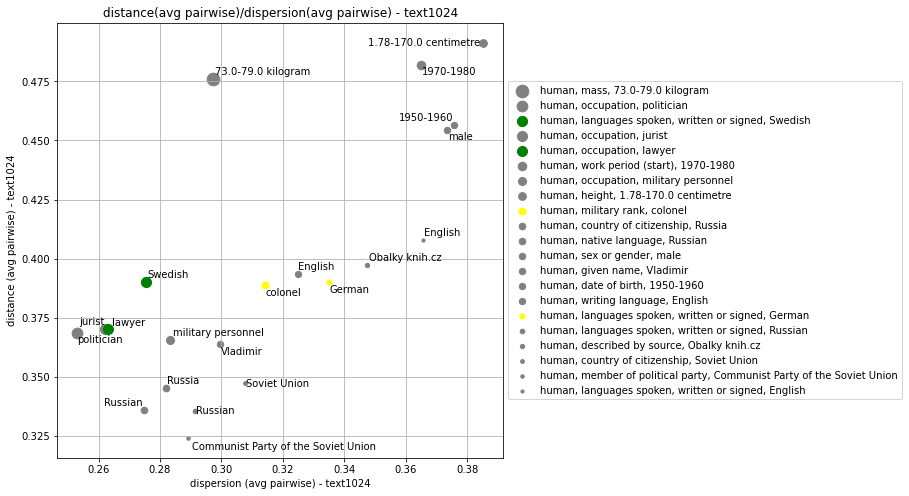

In [147]:
disp_col = f"dispersion (avg pairwise) - {emb_model_name}"
dist_col = f"distance (avg pairwise) - {emb_model_name}"
size_col = f"distance(avg pairwise)/dispersion(avg pairwise) - {emb_model_name}"
plot_surprise_metrics(ent_to_facts_df[ent], disp_col, dist_col, "plab_label", size_col, "surprise_label")


## Visualizing some embeddings and looking into weird result

**Why is the mass sample for putin so compact???**  
Let's look at some of the entities who have this...

In [318]:
mass_sample = list(get_entities_with_profile_label("Q5_P2067_73.0-79.0__Q11570", limit=1000, label_to_ents_dict=human_label_to_ents_dict))
mass_sample_embeds = [embedding_models["text"][ent] for ent in mass_sample]
mass_sample_centroid = np.mean(mass_sample_embeds, axis=0)
dists = [distance.cosine(mass_sample_centroid, e) for e in mass_sample_embeds]

Results was that all entities near centroid are soccer players. Soccer players are more likley to have mass filled out than other humans.

### Looking at entity vs sample for specific profile labels

In [333]:
ent = "Q7747"
ent_embed = embedding_models["text"][ent]
# label_id = "Q5_P410_Q104680"  # military rank colonel 
# label_id = "Q5_P106_Q40348"  # lawyer
# label_id = "Q5_P2048_1.78-170.0__Q174728"  # height
label_id = "Q5_P2067_73.0-79.0__Q11570" # mass
# label_id = "Q5_P1412_Q9027"  # languages = sweden
ents_sharing_label = get_entities_with_profile_label(label_id, ent, 10000, human_label_to_ents_dict)
sample_embeds = np.array([embedding_models["text"][e] for e in ents_sharing_label if e in embedding_models["text"]])
centroid = np.mean(sample_embeds, axis=0)

# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir=f'{output_dir}/logs/putin_mass/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for sample_ent in ents_sharing_label:
        if sample_ent not in embedding_models["text"]:
            continue
        f.write(f"{sample_ent} ({labels_en_dict[sample_ent]})\n")
    f.write(f"sample centroid\n")
    f.write(f"{ent} ({labels_en_dict[ent]})\n")

# Save the weights we want to analyze as a variable.
weights = tf.Variable(np.vstack([sample_embeds,centroid,ent_embed]))
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [338]:
weights.shape

TensorShape([9959, 100])

Putin -- military rank

In [288]:
%tensorboard --logdir {log_dir} --port 6008

Reusing TensorBoard on port 6008 (pid 36417), started 1:27:49 ago. (Use '!kill 36417' to kill it.)

Putin -- Mass

In [337]:
%tensorboard --logdir {log_dir} --port 6009

Reusing TensorBoard on port 6009 (pid 48849), started 0:14:57 ago. (Use '!kill 48849' to kill it.)

Putin -- height

In [292]:
%tensorboard --logdir {log_dir} --port 6010

Reusing TensorBoard on port 6010 (pid 36008), started 1:35:25 ago. (Use '!kill 36008' to kill it.)

languages = swedish

In [261]:
%tensorboard --logdir {log_dir} --port 6012

Reusing TensorBoard on port 6012 (pid 35326), started 0:03:49 ago. (Use '!kill 35326' to kill it.)

## Try computing suprise(fact2 | fact1)

In [ ]:
def compute_label_dists_and_disps(labels_list, embedding_dict, 
                                  label_to_ents_dict, sample=10000, pairwise_sample=10000):
    label_to_sample = {}
    for l in labels_list:
        sample_ents = get_entities_with_profile_label(l, limit=sample, label_to_ents_dict=label_to_ents_dict)
        sample_embeds = np.array([embedding_dict[e] for e in sample_ents])
        label_to_sample[l] = sample_embeds

    disps = {}
    for l, sample_embeds in label_to_sample.items():
        # avg pairwise dist within sample
        sample_dists = []
        for i in range(pairwise_sample):
            e1, e2 = sample_embeds[np.random.choice(sample_embeds.shape[0], size=2, replace=False), :]
            sample_dists.append(distance.cosine(e1, e2))
        avg_sample_to_sample = np.mean(sample_dists)
        disps[l] = avg_sample_to_sample
        
    dists = {}
    for l1, sample_embeds1 in label_to_sample.items():
        for l2, sample_embeds2 in label_to_sample.items():
            # skip if labels are same
            if l1==l2:
                continue
            # init first level of dictionary
            if l1 not in dists:
                dists[l1] = {}
            if l2 not in dists:
                dists[l2] = {}
            # we may have already computed this. If we have, then l2 will be in l1's dict and vice versa
            if l2 not in dists[l1]:
                TODO
                
                
                       

### Putin again

In [268]:
ent="Q7747"
labels_list = list(ent_to_profile_labels_df[ent]["id"])

In [270]:
label_dists, label_disps = compute_label_dists_and_disps(labels_list, embedding_models["text"], 
                                                         human_label_to_ents_dict, sample=10000, pairwise_sample=10000)


,id,plab_label,support,distinctiveness,surprise_label,dispersion (centroid) -- text,distance (centroid) -- text,distance (avg pairwise) -- text,dispersion (avg pairwise) -- text,distance(centroid)/dispersion(centroid) -- text,distance(avg pairwise)/dispersion(centroid) -- text,distance(avg pairwise)/dispersion(avg pairwise) -- text
368140,Q5_P21_Q6581097,"human, sex or gender, male",0.5779681838190067,0.175249,0,0.459792,0.878898,0.934537,0.708789,1.911513,2.032521,1.318497
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663,0,0.295231,0.667556,0.764844,0.505178,2.261131,2.590662,1.514009
368151,Q5_P1412_Q1860,"human, languages spoken, written or signed, En...",0.025629212807962157,0.263496,0,0.430575,0.664019,0.806316,0.678580,1.542166,1.872649,1.188240
368154,Q5_P1412_Q188,"human, languages spoken, written or signed, Ge...",0.019660259037766203,0.354203,1,0.410927,0.644577,0.788738,0.653401,1.568593,1.919412,1.207127
368181,Q5_P106_Q40348,"human, occupation, lawyer",0.008697859135084906,0.243468,2,0.311993,0.660482,0.765957,0.527901,2.116978,2.455045,1.450949
368186,Q5_P27_Q15180,"human, country of citizenship, Soviet Union",0.007849251764756461,0.416726,0,0.371929,0.541399,0.709657,0.603842,1.455652,1.908048,1.175237
368191,Q5_P106_Q47064,"human, occupation, military personnel",0.0069975909712475005,0.243525,0,0.331771,0.608185,0.736354,0.554334,1.833146,2.219461,1.328358
368194,Q5_P27_Q159,"human, country of citizenship, Russia",0.0068761868655902655,0.392806,0,0.304808,0.545132,0.682417,0.515531,1.788446,2.238844,1.323717
368211,Q5_P1343_Q67311526,"human, described by source, Obalky knih.cz",0.005793687279634449,0.228881,0,0.434292,0.677824,0.814774,0.680180,1.560758,1.876098,1.197880
368260,Q5_P1412_Q7737,"human, languages spoken, written or signed, Ru...",0.003758763935212711,0.414013,0,0.364229,0.523397,0.694026,0.596603,1.437002,1.905467,1.163296


## FunFacts data from wikipedia mapped to WD

In [243]:
funfacts_df = pd.read_csv("/data02/profiling/FunFacts/experiment_results/evaluation_study/funfacts_mapped_to_wd.tsv", sep='\t').fillna("")


In [244]:
funfacts_df

,Input.Article,Article.wd,Input.Fact,fact.wd,Input.Type,in WD?,likely in profiles?,goodTrivia,knew,surprising
0,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Indian...,"P27=Q668,P106=Q10497074",ourMiddle,1.0,1.0,0.00,-2.0,0.4
1,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Nuclea...,,ourTop,0.0,0.0,-0.20,-2.0,-0.2
2,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Recipi...,P166=Q932650,ourBottom,1.0,0.0,-0.60,-2.0,-0.6
3,A. P. J. Abdul Kalam,Q9513,"On 10 June 2002, the National Democratic Allia...",,baseline,0.0,0.0,-0.40,-2.0,-0.2
4,Abraham Lincoln,Q91,Abraham Lincoln is in the group of Presidents ...,,ourBottom,1.0,0.0,-1.80,1.2,-1.8
...,...,...,...,...,...,...,...,...,...,...
357,Winston Churchill,Q8016,Winston Churchill is in the group of British m...,,ourTop,,,-0.60,-2.0,-0.2
358,Winston Churchill,Q8016,Winston Churchill is in the group of UK MPs 19...,,ourMiddle,,,-0.40,-1.2,-0.2
359,Zlatan IbrahimoviÄ‡,Q46896,"On 27 November 2013, Ibrahimović made his 100t...",,baseline,,,-0.25,-1.2,0.0
360,Zlatan IbrahimoviÄ‡,Q46896,Zlatan IbrahimoviÄ‡ is in the group of Expatri...,,ourMiddle,,,-0.60,-1.2,-0.6


In [249]:
mask = [fact != "" and '_' not in fact for fact in funfacts_df.loc[:,"fact.wd"]]
masked_ff_df=funfacts_df.loc[mask]

In [250]:
with pd.option_context("max_colwidth",None):
    display(masked_ff_df)

,Input.Article,Article.wd,Input.Fact,fact.wd,Input.Type,in WD?,likely in profiles?,goodTrivia,knew,surprising
0,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Indian aerospace engineers,"P27=Q668,P106=Q10497074",ourMiddle,1.0,1.0,0.00,-2.0,0.4
2,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Recipients of the Padma Vibhushan,P166=Q932650,ourBottom,1.0,0.0,-0.60,-2.0,-0.6
7,Akshay Kumar,Q233748,Akshay Kumar is in the group of Canadian game show hosts,"P27=Q16,P106=Q22662561",ourTop,0.0,0.0,-0.60,-2.0,-0.4
8,Akshay Kumar,Q233748,Akshay Kumar is in the group of Indian stunt performers,"P27=Q668,P106=Q465501",ourMiddle,0.0,0.0,-0.60,-2.0,-0.6
10,Alan Rickman,Q106481,Alan Rickman is in the group of 20th-century English male actors,"cent20,P27=Q145,P21=Q6581097,P106=Q33999",ourMiddle,1.0,2.0,-1.40,2.0,-1.6
12,Alan Rickman,Q106481,Alan Rickman is in the group of English male voice actors,"P27=Q145,P21=Q6581097,P106=Q2405480",ourBottom,1.0,1.0,-1.20,1.2,-1.2
14,Albert Einstein,Q937,Albert Einstein is in the group of 20th-century physicists,"cent20,P106=Q169470",ourBottom,1.0,0.0,-1.40,2.0,-2.0
15,Albert Einstein,Q937,Albert Einstein is in the group of American Zionists,"P27=P30,P106=Q12718299",ourTop,0.0,0.0,0.25,-0.4,0.4
18,Alec Baldwin,Q170572,Alec Baldwin is in the group of 20th-century American male actors,"cent20,P27=Q30,P21=Q6581097,P106=Q33999",ourBottom,1.0,2.0,-1.80,2.0,-1.8
24,Alicia Vikander,Q439314,"Alicia Amanda Vikander (born 3 October 1988) is a Swedish actress, producer and dancer.","P27=Q34,P21=Q6581072,P106=Q33999,P106=Q3282637,P106=Q5716684",baseline,1.0,1.0,-0.80,-1.2,-0.8


In [251]:
def get_fact_ids_from_str(fact_strs):
    fact_ids = []
    for fact_str in fact_strs.split(','):
        if "cent" in fact_str:
            # TODO - handle century fact here
            continue
        else:
            fact_ids.append("Q5_" + '_'.join(fact_str.split('=')))
    return fact_ids

count_rows_w_facts_in_profiles = 0
count_rows_w_facts_in_profiles_and_entity_has_them = 0
for ent, fact_strs in zip(masked_ff_df.loc[:,"Article.wd"], masked_ff_df.loc[:,"fact.wd"]):
    fact_ids = get_fact_ids_from_str(fact_strs)
    if sum([f in label_to_ents_dict for f in fact_ids]) == len(fact_ids):
        count_rows_w_facts_in_profiles += 1
        if sum([f in ent_to_labels_dict[ent] for f in fact_ids]) == len(fact_ids):
             count_rows_w_facts_in_profiles_and_entity_has_them += 1
    
print(f"count_rows_w_facts_in_profiles: {count_rows_w_facts_in_profiles}")
print(f"count_rows_w_facts_in_profiles_and_entity_has_them: {count_rows_w_facts_in_profiles_and_entity_has_them}")

count_rows_w_facts_in_profiles: 32
count_rows_w_facts_in_profiles_and_entity_has_them: 27


In [253]:
sum(["|" in f for f in masked_ff_df.loc[:,"fact.wd"]])

3